# Fault Localization with Deep Neural Networks (Capstone Project)
* Variable names are chosen to reflect their actual use, so I kept comments to a minimum. If that is not enough, I will gladly change that.
* Red Headers indicate that the user can change the parameters here
* Global Variables that have a higher role in the context of the whole program are explained in tables prior to a code snippet in order to emphasize their general existence in the code

## Preparation

### Imports


| **Import Name** | **Usage** |
|:-|:-|:-|
| **Path.pathlib** | Saving, loading and checking paths |
| **random** | Generating random numbers |
| **numpy** | Math package |
| **pandas** | Used for csv file reading |
| **operator** | easy sorting by second dimension |
| **copy** | Used to copy lists |
| **sklearn** | used for agglomerative clustering and silhouette metric |
| **tensorflow** | DNN framework |
| **matplotlib** | Visualization |

In [1]:
from pathlib import Path
import random as rd
import numpy as np
import pandas as pd
import operator
import copy
import sklearn
from sklearn import cluster
from sklearn import metrics
import tensorflow as tf
import matplotlib.pyplot as plt

bug_path = "training_bugs/"
applications = ["Chart","Time","Mockito","Lang","Math","Closure"]

### Choice of Faults: <font color='red'>User Changes</font>

In [2]:
fault_nr = [[2,14,21,25], #Chart
[1,3,5,9,18,21,23], #Time
[1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,28,29,30,31,32,33,34,35,36,37,38], #Mockito
[30,32,36,63], #Lang
[6,8,16,38,51,64,66,71], #Math
[3,16,26,27,37,43,47,49,72,76,103,108]] #Closure

# Possible Choices
#[[2,14,21,25], #Chart
#[1,3,5,9,18,21,23], #Time
#[1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,28,29,30,31,32,33,34,35,36,37,38], #Mockito
#[30,32,36,41,63], #Lang
#[6,8,16,38,51,64,66,71,92,97], #Math
#[3,16,26,27,37,43,47,49,72,76,103,108]] #Closure

### Some Parameters: <font color='red'>User Changes</font>
The Parameters in the following code snippet can be adjust as the user sees fit.

In [3]:
batch_size = 1 # Should be set to 1, but can be changed

# Deliberate naming in order to not confuse code for short and long runnning model
long_training_model = False
short_training_model = not long_training_model

PCA_flag = False
cluster_flag = False

granularity = "method"

### Reading and preparing gzoltar output

| **Variable Name** | **Type** | **Definition** |
|:-|:-|:-|
| **stats_by_appbug** | **List of List of Int** | Contains general statistics for every fault |
| **column_names** | **Dictionary** | Maps column names to numbers as given by the csv-file. |

In [4]:
stats_by_appbug = [[] for i in range(len(applications))]
#listing of statistics for every bug of every application

column_names = {"NUMBER_OF_COMPONENTS": 0,"AMBIGUITY_GROUPS": 1,"INFORMATION_GAIN": 2,"NUMBER_OF_CLASSES":3,"NUMBER_OF_TEST_CLASSES": 4,"NUMBER_OF_UNIT_TEST_CASES": 5,"RHO": 6}

for i in range(len(applications)):
    for j in range(len(fault_nr[i])):
        gzoltar_data_dir = "./data/"+applications[i]+"/"+applications[i]+"_"+str(fault_nr[i][j])+"/gzoltar/"+granularity+"_gran/statistics.csv"
        
        if Path(gzoltar_data_dir).exists():
            stats = pd.read_csv(gzoltar_data_dir)
            stats = (stats.values)[0]
            stats_by_appbug[i].append(stats)
        else: 
            stats_by_appbug.append(["Nope this file is missing"])
            print("Missing File")
            raise RuntimeError("Missing File: " + str(gzoltar_data_dir))
        

### Read List of Faulty Components
Setup solutions. Finds the different faulty methods, their id number and their names.

| **Variable Name** | **Type** | **Definition** |
|:-|:-|:-|
| **faulty_component_list** | **List of List of List of Int** | Contains a List of faulty methods for every fault |

In [5]:
# Matching components

faulty_component_list = []


for i in range(len(applications)):
    fc_by_application = []
       
    data_dir = "./data/"+applications[i]+"/faulty_components"

    if Path(data_dir).exists():
        faulty_components_file = open(data_dir)
        j=0
        
        #The structure with while is based on the formatting of the faulty component list file.
        while j<len(fault_nr[i]):
            fc_by_bug = []
            header_line = faulty_components_file.readline().split(" ")
            remaining_lines = int(header_line[1]) 
            #reads remaining lines to ensure capability to also use only singular bugs instead of all
            
            faulty_components = []
            spectra_dir = "./data/"+applications[i]+"/"+applications[i]+"_"+str(fault_nr[i][j])+"/gzoltar/"+granularity+"_gran/spectra"
            if Path(spectra_dir).exists():
                spectra_file = open(spectra_dir)
                spectra_file.readline()
                component = faulty_components_file.readline().replace("/",".")
                num_components = int(stats_by_appbug[i][j][column_names["NUMBER_OF_COMPONENTS"]])
                
                for l in range(num_components):
                    line = spectra_file.readline()
                    if line == component:
                        fc_by_bug.append(l)
                        component = faulty_components_file.readline().replace("/",".") #need to change
                        remaining_lines-=1

            if not int(header_line[0]) in fault_nr[i]:
                #Continue empty read on bugs that are not in the list to be evaluated
                for k in range(remaining_lines):
                    faulty_components_file.readline()
                continue
                
            j+=1
            fc_by_application.append(fc_by_bug)
    faulty_component_list.append(fc_by_application)

### Find names for every faulty component

In [6]:
def faulty_component_names(application_i, bug_j):
    #Retrieves original names of the faulty methods.
    faulty_component_names_list = []
    data_dir = "./data/"+applications[application_i]+"/faulty_components"

    if Path(data_dir).exists():
        spectra_dir = "./data/"+applications[application_i]+"/"+applications[application_i]+"_"+str(fault_nr[application_i][bug_j])+"/gzoltar/"+granularity+"_gran/spectra"
        if Path(spectra_dir).exists():
            spectra_file = open(spectra_dir)
            spectra_file.readline()
            num_components = int(stats_by_appbug[application_i][bug_j][column_names["NUMBER_OF_COMPONENTS"]])

            for l in range(num_components):
                line = spectra_file.readline()
                faulty_component_names_list.append(line[:-1])
                
    return faulty_component_names_list

### Get and prepare Spectra Data

In [7]:
def get_test_coverage(application_i, bug_j):
    
    #spectrum data and their labels. Main data for the project.
    spectrum_data = list() 
    spectrum_labels = list()
    gzoltar_data_dir = "./data/"+applications[application_i]+"/"+applications[application_i]+"_"+str(fault_nr[application_i][bug_j])+"/gzoltar/"+granularity+"_gran/matrix"

    if Path(gzoltar_data_dir).exists():
        
        #important_columns are all colums that are executed by at least one failing test case        
        important_column_numbers = set()
        
        matrix_file = open(gzoltar_data_dir)
        for line in matrix_file.readlines():

            line = line.split(" ")
            if line[-1]=='+\n':
                line[-1] = 0 #0 for passing test
            else: # always '-'
                line[-1] = 1 #1 for failing test
                            
            y = line[-1]
            X = line[:-1]
            
            if y==1:
                for i in range(len(X)): #Filter down to union of components executed by faulty test cases.
                    if X[i]=="1":
                        important_column_numbers.add(i) 
                        
            spectrum_data.append(X)
            spectrum_labels.append(y)
    
    #print(important_column_numbers)
    spectrum_data_reduced = list()
    important_column_numbers = list(important_column_numbers)
    
    for line in spectrum_data:
        line = [int(i) for i in line]
        spectrum_data_reduced.append([line[i] for i in important_column_numbers])

    return spectrum_data_reduced, spectrum_labels, important_column_numbers

### PCA Transformation

In [8]:
from sklearn import decomposition

def PCA(spectrum_data, virtual):
    combined = spectrum_data+virtual
    PCA = decomposition.PCA(svd_solver='full')
    transformed = PCA.fit_transform(combined)
    return transformed[:len(spectrum_data)], transformed[len(spectrum_data):]

### Label Adaption through Clustering

In [9]:
def agglomerative_cluster_adaption(spectrum_data, spectrum_labels):
    #Change labels to be based on the number of failing test cases in a cluster
    
    lower = 2 #minimum number of clusters
    upper = min(len(spectrum_data)//2, len(spectrum_data)//500+8) #maximum number of clusters
    best_score = -1
    best_cluster_num = -1
    
    #get best number of clusters based on silhouette score
    for i in range(lower, upper, 1):
        model = cluster.AgglomerativeClustering(n_clusters = i)
        predictions = model.fit_predict(spectrum_data)
        score = metrics.silhouette_score(spectrum_data,predictions)
        if score>best_score:
            best_score = score
            best_cluster_num = i
        print(str(i) + " Clusters: "+ str(score))
        
    model = cluster.AgglomerativeClustering(n_clusters = best_cluster_num)
    predictions = model.fit_predict(spectrum_data)
    
    passes_per_cluster = [0 for i in range(best_cluster_num)]
    fails_per_cluster = [0 for i in range(best_cluster_num)]
    
    
    for i in range(len(spectrum_labels)):
        if spectrum_labels[i] == 0:
            passes_per_cluster[predictions[i]] += 1.0
        else:
            fails_per_cluster[predictions[i]] += 1.0
 
    for i in range(len(spectrum_labels)):
        if spectrum_labels[i] == 0.0:
            spectrum_labels[i] = np.sqrt(fails_per_cluster[predictions[i]]/(passes_per_cluster[predictions[i]]+fails_per_cluster[predictions[i]]))
    
    return spectrum_data, spectrum_labels

### Shuffle Data Batches

In [10]:
def shuffle(features, labels):
    #shuffeling of batches. Added in case batch_size is increased
    
    shuffled_f = np.empty(features.shape, dtype=features.dtype)
    shuffled_l = np.empty(labels.shape, dtype=labels.dtype)
    permutation = np.random.permutation(len(features))
    
    for old_index, new_index in enumerate(permutation):
        shuffled_f[new_index] = features[old_index]
        shuffled_l[new_index] = int(labels[old_index])
    
    return shuffled_f, shuffled_l

### Batch Data

In [11]:
def batching_data(features, labels):
    num_data = len(features)    
    num_batches = num_data//batch_size
    
    training_input = []
    training_label = []
    for i in range(0, num_data, batch_size):
        if i+batch_size<=num_data:
            training_input.append([features[i:i+batch_size]])
            training_label.append([labels[i:i+batch_size]])
    
    if not num_data%batch_size==0:
        training_input.append([features[num_batches*batch_size:]])
        training_label.append([labels[num_batches*batch_size:]])
        num_batches+=1
        
    return training_input, training_label

# Neural Network

### Activation and Layer Functions

In [12]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def lrelu(layer, alpha=0.05):
    return tf.maximum(alpha*layer, layer)

def fully_connected(prev_layer, num_targets, num, is_training):
    weights = tf.get_variable("weights"+str(num), shape=[prev_layer.get_shape().as_list()[1], num_targets], initializer=tf.contrib.layers.xavier_initializer())
    layer = tf.matmul(prev_layer, weights)
    layer = tf.layers.batch_normalization(layer, training=is_training)
    return layer

def out_layer(prev_layer, num_targets, num):
    weights = tf.get_variable("weights"+str(num), shape=[prev_layer.get_shape().as_list()[1], num_targets], initializer=tf.contrib.layers.xavier_initializer())
    bias = tf.Variable(tf.truncated_normal([num_targets],stddev=0.01))
    layer = tf.add(tf.matmul(prev_layer, weights), bias)
    return layer

### Network Setup

In [13]:
def set_network(input_tensor, keep_prob, sizes, num_out, is_training):
    #3 layer setup with dynamic sizes based on the fault
    
    layer0 = fully_connected(input_tensor, sizes[0],0,is_training)
    layer0 = lrelu(layer0)
    
    layer1 = fully_connected(layer0, sizes[1],1,is_training)
    layer1 = lrelu(layer1)
    
    layer2 = fully_connected(layer1, sizes[2],2,is_training)
    layer2 = lrelu(layer2)
    
    output_layer = out_layer(input_tensor, num_out,3)
    
    return output_layer

### Helper Functions

In [14]:
def get_train_batch(batch_i):
    for i in range(len(training_input[batch_i])):
        yield np.reshape(training_input[batch_i][0][i], (1,num_inputs)), np.reshape(training_label[batch_i][0][i],(1,1))
    
def print_stats(sess, batch_i, batch_features, batch_labels, cost):
    train_loss = sess.run(cost, feed_dict={input_tensor: batch_features, labels: batch_labels, keep_prob: 1.0, is_training: False})
            
    print('Loss: {:>10.8f}'.format(train_loss))
    return train_loss

def get_loss(sess, batch_i, batch_features, batch_labels, cost):
    train_loss = sess.run(cost, feed_dict={input_tensor: batch_features, labels: batch_labels, keep_prob: 1.0, is_training: False})

    return train_loss

### Neural Network Training Main Step
This method is the complete training step of a single network (for one fault). It is a step by tep ranking in order to allow visualizations as found below.

In [15]:
def step_by_step_ranking(network_num, application_i, fault_nr_j):
    rank_over_time=[]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        #Number of epochs between break update
        average_break_step = 5 
        
        #some initialization value >0 (will change after every epoch)
        average_break = 10 
        
        #Cumulative breaking sum. Break when current_break<average_break
        current_break=0
        
        #Ranking over time for evaluation visualization
        rank_over_time=[[] for i in range(len(faulty_component_list[application_i][fault_nr_j]))]
        
        #dictionary for all components of a fault
        component_dict = {}
        for i in range(len(faulty_component_list[application_i][fault_nr_j])):
            component_dict[faulty_component_list[application_i][fault_nr_j][i]] = i
    
    
        for i in range(epoch):
        
            if average_break<current_break: #stopping condition
                break
                
            if i%average_break_step==0: #reset value (since this is not cumulative)
                average_break=0
                
            #standard trainer
            for batch_i in range(num_batches):
                for batch_features, batch_labels in get_train_batch(batch_i):
                    sess.run(optimizer, feed_dict={input_tensor: batch_features, labels: batch_labels,
                                                   keep_prob: keep_probability, learn_rate: learning_rate, is_training: True})
                
                
                #update average break (as sum of all current losses of the batch)
                if i%average_break_step==0:
                    # short version
                    if short_training_model:
                        average_break += (get_loss(sess, batch_i, batch_features, batch_labels, cost))*500
                    
                    # long version
                    elif long_training_model:
                        average_break += (get_loss(sess, batch_i, batch_features, batch_labels, cost))
                        
            #update current_break value and give general printouts
            if i%average_break_step==0:
                print_stats(sess, batch_i, batch_features, batch_labels, cost)
                print('Epoch {:<2}, Batch {}: '.format(i+1, batch_i))
                average_break/=len(training_input)
                if short_training_model:
                    current_break += np.log(1+(i**4)/(average_break))*i*2/(average_break**2)
                elif long_training_model:
                    current_break += np.log(1+(i**4)/(average_break))*i*0.8/(average_break**2)
                print("Required to break:" + str(average_break)+"     Current:"+str(current_break))

                #save models for reconstruction.
                saver = tf.train.Saver()
                saver.save(sess,save_path+"_network_"+str(network_num))
                
            #produce current ranking for visualization
                ranking = []

                #get ranking of a component by running virtual set on current model
                for i in range(len(virtual_test_set)): 
                    virtual_feature = virtual_test_set[i]
                    virtual_feature = np.reshape(virtual_feature, [1,len(virtual_feature)])
                    output = sess.run(logits, feed_dict={input_tensor: virtual_feature, labels: batch_labels, keep_prob: keep_probability, learn_rate: learning_rate, is_training: False})[0,:]
                    ranking.append([column_to_component_list[i],sigmoid(output[0])])
                
                faulty_comps = faulty_component_list[application_i][fault_nr_j]
                ranking.sort(key=operator.itemgetter(1), reverse=True)

                for i in range(len(ranking)):
                    if ranking[i][0] in faulty_comps:
                        rank_over_time[component_dict[ranking[i][0]]].append(i)
                        
                        
           
    return rank_over_time #return all rankings

### Testing: get Suspciousness Values
Retrieves the suspiciousness values for all components of trained model.

In [16]:
def test_NN(network_num):
    loaded_graph = tf.Graph()
    load_path = save_path+"_network_"+str(network_num)

    ranking = []

    with tf.Session(graph=loaded_graph) as sess:
        loader = tf.train.import_meta_graph(load_path + '.meta')
        loader.restore(sess, load_path)

        loaded_input = loaded_graph.get_tensor_by_name('input_tensor:0')
        loaded_label = loaded_graph.get_tensor_by_name('labels:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_training = loaded_graph.get_tensor_by_name('is_training:0')
    
    
        #get ranking of a component by running virtual set on loaded model
        for i in range(num_inputs):
            virtual_feature = virtual_test_set[i]
            virtual_feature = np.reshape(virtual_feature, [1,len(virtual_feature)])
            output = sess.run(loaded_logits, feed_dict={loaded_input: virtual_feature, loaded_keep_prob: keep_probability, loaded_training: False})[0,:]

            ranking.append([column_to_component_list[i],sigmoid(output[0])])
            
    return ranking

### Tarantula and Ochiai
Evaluates Tarantula and Ochiai for a given fault. Returns a full ranking for a fault.

In [17]:
def tarantula_ochiai(application_i, fault_nr_j, spectrum_data, spectrum_labels, column_to_component_list):
    
    #First get all fails and passes for all components executed by some test.
    num_unit_tests = len(spectrum_labels) #all tests
    num_fail = np.sum(spectrum_labels) #failed tests
    num_pass = num_unit_tests - num_fail #passed tests
    num_components = len(spectrum_data[0])
    executed_fail = np.zeros(num_components) 
    executed_pass = np.zeros(num_components)
    
    for components, fail_pass in zip (spectrum_data[:], spectrum_labels):
        if fail_pass == 0: # 0 is pass
            executed_pass += components #accumulates number of tests a component passed
        else:
            executed_fail += components #accumulates number of tests a component failed
        
    #infer how many failed tests were not executed by a component
    not_exec_fail = [num_fail - executed_fail[i] for i in range(num_components)]
    
    #infer how many passed tests were not executed by a component
    not_exec_pass = [num_pass - executed_pass[i] for i in range(num_components)]
    
    component_dict = {}
    for i in range(len(faulty_component_list[application_i][fault_nr_j])):
        component_dict[faulty_component_list[application_i][fault_nr_j][i]] = i
    
    ranking_tarantula = []
    ranking_ochiai = []
    
    for i in range(num_components):
        #as documented in the paper for the benchmarks
        cef = executed_fail[i]
        cep = executed_pass[i]
        cnp = not_exec_pass[i]
        cnf = not_exec_fail[i]
        
        #Tarantula and Ochiai Formulas
        ranking_tarantula.append([column_to_component_list[i],((cef/(cef+cnf))/(cef/(cef+cnf)+cep/(cep+cnp)))])
        ranking_ochiai.append([column_to_component_list[i],(cef/np.sqrt((cef+cnf)*(cep+cnp)))])
            
    faulty_comps = faulty_component_list[application_i][fault_nr_j]
    ranking_tarantula.sort(key=operator.itemgetter(1), reverse=True)
    ranking_ochiai.sort(key=operator.itemgetter(1), reverse=True)
    
    return ranking_tarantula, ranking_ochiai

### Best Rank, average_break Rank and Worst Rank

In [18]:
def get_ranks(ranking):
    best_rank = []
    average_break_rank = []
    worst_rank = []
    current_rank_best = 1
    current_rank_worst = len(ranking)
    previous_best = -1
    previous_worst = -1
    
    
    #As documented in the paper. Get Best ranking and worst ranking. Then infer average ranking.
    # e.g. suspiciousness values of [0.5, 0.5, 0.5, 0.2]
    # best rank: [1, 1, 1, 4]
    # worst rank: [3, 3, 3, 4]
    # average rank: [2, 2, 2, 4]
    
    for i in range(len(ranking)):
        if not previous_best == ranking[i][1]:
            current_rank_best=i+1
            previous_best = ranking[i][1]
        best_rank.append([ranking[i][0], ranking[i][1], current_rank_best])
        
        if not  previous_worst == ranking[len(ranking)-i-1][1]:
            current_rank_worst=len(ranking)-i
            previous_worst = ranking[len(ranking)-i-1][1]
        worst_rank.insert(0,[ranking[len(ranking)-i-1][0], ranking[len(ranking)-i-1][1], current_rank_worst])
        
    for i in range(len(ranking)):
        average_break_rank.append([ranking[i][0], ranking[i][1], (best_rank[i][2]+worst_rank[i][2])//2])
        
    return best_rank, average_break_rank, worst_rank

### Shell for avg rerun Methods
**rerun** was implemented originally to expand into Ensemble methods. However, that was decidedly to time intensive and was removed from the scope of the project. This is a remnant, in order to preserve easy adjustments in case Ensembling will be implemented later on.

In [19]:
def rerun(network_num, application_i, fault_nr_j):
    rank_over_time = []
    rank_over_time = step_by_step_ranking(network_num, application_i, fault_nr_j)
    return test_NN(network_num), rank_over_time

## Main Loop
Sets up hyperparameters and trains all Neural networks and their respective results. Those are saved and used in the next step. Also evaluates Tarantula and Ochiai.

In [20]:
top_ranking = [[] for i in range(len(fault_nr))]
ranking_over_time_all = [[] for i in range(len(fault_nr))]
tarantula_ranking_all = [[] for i in range(len(fault_nr))]
ochiai_ranking_all = [[] for i in range(len(fault_nr))]

for application_i in range(len(fault_nr)):
    for fault_nr_j in range(len(fault_nr[application_i])):
        epoch = 50000 #automated breaks, this is maximum

        #=====Preparation====

        spectrum_data, spectrum_labels, column_to_component_list = get_test_coverage(application_i, fault_nr_j)
        
        tarantula_ranking, ochiai_ranking = tarantula_ochiai(application_i, fault_nr_j, spectrum_data, spectrum_labels, column_to_component_list)
        tarantula_ranking_all[application_i].append(copy.deepcopy(tarantula_ranking))
        ochiai_ranking_all[application_i].append(copy.deepcopy(ochiai_ranking))
        
        virtual_test_set = [[1 if j==i else 0 for j in range(len(spectrum_data[0]))] for i in range(len(spectrum_data[0]))]
        
        if cluster_flag:
            spectrum_data, spectrum_labels = agglomerative_cluster_adaption(spectrum_data, spectrum_labels)
            
        if PCA_flag:
            spectrum_data, virtual_test_set = PCA(spectrum_data, virtual_test_set)

        #--data--
        spectrum_data, spectrum_labels = shuffle(np.array(spectrum_data), np.array(spectrum_labels))
        training_input, training_label = batching_data(spectrum_data, spectrum_labels)
        
        #--in and out settings of NN--
        num_outputs = 1
        num_inputs = len(spectrum_data[0])
        
        #--other NN parameters--
        hidden_layer_sizes = [int(np.round(num_inputs/50)*16)+40,int(np.round(num_inputs/50)*8)+30,
                              int(np.round(num_inputs/50)*4)+20]
        learning_rate = 2/(len(spectrum_data)*1.2)
        keep_probability = 0.8
        
        #--checking prints--
        print(learning_rate)
        print(len(spectrum_data))
        print(hidden_layer_sizes)
        
        #--batches and path--
        num_batches = len(spectrum_data)//batch_size + (1 if not len(spectrum_data)%batch_size==0 else 0)
        save_path = "./models/"+applications[application_i]+"/"+applications[application_i]+"_"+str(fault_nr[application_i][fault_nr_j])+"/save"
        print(save_path)

        
        #=====set Neural Network=====
        
        tf.reset_default_graph()

        learn_rate = tf.placeholder(tf.float32, name="learn_rate")
        input_tensor = tf.placeholder(tf.float32, [None, num_inputs], name="input_tensor")
        keep_prob = tf.placeholder(tf.float32, name="keep_prob")
        labels = tf.placeholder(tf.float32, [None,num_outputs], name="labels")
        is_training = tf.placeholder(tf.bool, name="is_training")

        logits = set_network(input_tensor, keep_prob, hidden_layer_sizes, num_outputs, is_training)
        logits = tf.identity(logits, name="logits")

        cost = None
        optimizer = None
        
        #short version
        if short_training_model:
            cost = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=logits, targets=labels,                                                                pos_weight=1))
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
        
        #long version
        elif long_training_model:
            cost = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=logits, targets=labels, 
                                                                           pos_weight=100000*len(spectrum_labels)**2/(np.sum(spectrum_labels))+1))
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

            
        #=====Running====

        ranking, rank_over_time=rerun(0, application_i, fault_nr_j)
        ranking_over_time_all[application_i].append(copy.deepcopy(rank_over_time))
    
        ranking = [[x[0],x[1]] for x in ranking] #Had some weird behavior without this

        faulty_comps = faulty_component_list[application_i][fault_nr_j]
        ranking.sort(key=operator.itemgetter(1), reverse=True)
        faulty_component_names_list = faulty_component_names(application_i, fault_nr_j)

        #--prints for fully evaluated fault with the respective trained NN--
        print("Number of Components")
        print(str(len(ranking))+"\n")

        print("Faulty Component Ranking")
        for i in range(len(ranking)):
            if ranking[i][0] in faulty_comps:
                print("rank: "+str(i+1)+" "+str(faulty_component_names_list[ranking[i][0]]))
                print(ranking[i])
        print()
        
        print("Faulty Component Ranking for Tarantula and Ochiai")
        t_best, t_avg, t_worst = get_ranks(tarantula_ranking)
        o_best, o_avg, o_worst = get_ranks(ochiai_ranking)
        for i in range(len(ranking)):
            if tarantula_ranking[i][0] in faulty_comps:
                print("Tarantula: Best rank: "+str(t_best[i][2])+" Avg Rank: "+str(t_avg[i][2])+" Worst Rank: "+str(t_worst[i][2])+str(faulty_component_names_list[tarantula_ranking[i][0]]))
                print(tarantula_ranking[i])
            if ochiai_ranking[i][0] in faulty_comps:
                print("Ochiai: Best rank: "+str(o_best[i][2])+" Avg Rank: "+str(o_avg[i][2])+" Worst Rank: "+str(o_worst[i][2])+str(faulty_component_names_list[ochiai_ranking[i][0]]))
                print(ochiai_ranking[i])
        #print(ranking)
        print()
        
        print("Name of top 10 Ranking")
        for i in range(np.minimum(len(ranking),10)):
            print(str(faulty_component_names_list[ranking[i][0]]))

        print()
        print("Suspiciousness of top 10 Ranking")
        for i in range(np.minimum(len(ranking),10)):
            print(str(ranking[i]))

        print()
        top_ranking[application_i].append(copy.deepcopy(ranking))
        print("=========================================================\n")

0.004775549188156638
349
[56, 38, 24]
./models/Chart/Chart_2/save
Loss: 0.48454839
Epoch 1 , Batch 348: 
Required to break:194.350000268     Current:0.0
Loss: 0.31841296
Epoch 6 , Batch 348: 
Required to break:29.1544468833     Current:0.0365976792272
Loss: 0.25899422
Epoch 11, Batch 348: 
Required to break:20.3428773962     Current:0.336218387583
Loss: 0.22205162
Epoch 16, Batch 348: 
Required to break:15.6579372876     Current:1.32510354314
Loss: 0.19531572
Epoch 21, Batch 348: 
Required to break:12.6241347339     Current:3.69630766146
Loss: 0.17458832
Epoch 26, Batch 348: 
Required to break:10.5521249395     Current:8.41990635137
Loss: 0.15795028
Epoch 31, Batch 348: 
Required to break:9.06809032988     Current:16.7380403705
INFO:tensorflow:Restoring parameters from ./models/Chart/Chart_2/save_network_0
Number of Components
53

Faulty Component Ranking
rank: 23 org.jfree.data.general.DatasetUtilities#742
[172, 0.17297103270985795]
rank: 44 org.jfree.data.general.DatasetUtilities#123

Loss: 0.00000000
Epoch 1 , Batch 8: 
Required to break:11.1751423942     Current:0.0
Loss: 0.00000000
Epoch 6 , Batch 8: 
Required to break:1.74448225233     Current:19.3350607469
INFO:tensorflow:Restoring parameters from ./models/Chart/Chart_25/save_network_0
Number of Components
639

Faulty Component Ranking
rank: 6 org.jfree.chart.renderer.category.StatisticalBarRenderer#240
[744, 0.7221567954953354]
rank: 634 org.jfree.chart.renderer.category.StatisticalBarRenderer#383
[1016, 0.24175112885386857]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 1 Avg Rank: 5 Worst Rank: 9org.jfree.chart.renderer.category.StatisticalBarRenderer#240
[744, 1.0]
Tarantula: Best rank: 601 Avg Rank: 606 Worst Rank: 612org.jfree.chart.renderer.category.StatisticalBarRenderer#383
[1016, 0.7142857142857143]
Ochiai: Best rank: 624 Avg Rank: 631 Worst Rank: 638org.jfree.chart.renderer.category.StatisticalBarRenderer#240
[744, 0.44721359549995793]
Ochiai: Best rank: 624 Avg Rank: 631 Wo


0.0008832361773538244
1887
[184, 102, 56]
./models/Time/Time_5/save
Loss: 0.01004457
Epoch 1 , Batch 1886: 
Required to break:52.0479102645     Current:0.0
Loss: 0.00888443
Epoch 6 , Batch 1886: 
Required to break:35.3534571001     Current:0.0234215257727
Loss: 0.00693369
Epoch 11, Batch 1886: 
Required to break:32.2846428831     Current:0.133543027624
Loss: 0.00569439
Epoch 16, Batch 1886: 
Required to break:29.9558373564     Current:0.382043055013
Loss: 0.00478315
Epoch 21, Batch 1886: 
Required to break:28.0806899829     Current:0.820736605025
Loss: 0.00407505
Epoch 26, Batch 1886: 
Required to break:26.5469873274     Current:1.50159908284
Loss: 0.00351238
Epoch 31, Batch 1886: 
Required to break:25.2749884514     Current:2.47604479982
Loss: 0.00305939
Epoch 36, Batch 1886: 
Required to break:24.2051911468     Current:3.79444450348
Loss: 0.00268936
Epoch 41, Batch 1886: 
Required to break:23.2932886941     Current:5.50588531369
Loss: 0.00238419
Epoch 46, Batch 1886: 
Required to br

0.0004405674508767293
3783
[168, 94, 52]
./models/Time/Time_21/save
Loss: 0.00447655
Epoch 1 , Batch 3782: 
Required to break:48.2431512416     Current:0.0
Loss: 0.00750780
Epoch 6 , Batch 3782: 
Required to break:28.4296822176     Current:0.0387851960239
Loss: 0.00746918
Epoch 11, Batch 3782: 
Required to break:26.1229381119     Current:0.213171674107
Loss: 0.00697184
Epoch 16, Batch 3782: 
Required to break:24.83741969     Current:0.583752246358
Loss: 0.00647163
Epoch 21, Batch 3782: 
Required to break:23.91923888     Current:1.19958400799
Loss: 0.00604773
Epoch 26, Batch 3782: 
Required to break:23.1925437619     Current:2.10419813964
Loss: 0.00570250
Epoch 31, Batch 3782: 
Required to break:22.5845153941     Current:3.33788194112
Loss: 0.00542021
Epoch 36, Batch 3782: 
Required to break:22.0581930748     Current:4.93878292937
Loss: 0.00518513
Epoch 41, Batch 3782: 
Required to break:21.5924921062     Current:6.94346514475
Loss: 0.00498438
Epoch 46, Batch 3782: 
Required to break:21

Loss: 0.00000572
Epoch 16, Batch 29: 
Required to break:11.7117716291     Current:2.71832383249
Loss: 0.00000477
Epoch 21, Batch 29: 
Required to break:10.6759152763     Current:6.09274504196
Loss: 0.00000286
Epoch 26, Batch 29: 
Required to break:9.37482609103     Current:12.1445247089
INFO:tensorflow:Restoring parameters from ./models/Mockito/Mockito_2/save_network_0
Number of Components
184

Faulty Component Ranking
rank: 8 org.mockito.internal.util.Timer#7
[2, 0.6814174982974428]

Faulty Component Ranking for Tarantula and Ochiai
Ochiai: Best rank: 1 Avg Rank: 10 Worst Rank: 20org.mockito.internal.util.Timer#7
[2, 0.39223227027636809]
Tarantula: Best rank: 13 Avg Rank: 13 Worst Rank: 13org.mockito.internal.util.Timer#7
[2, 0.66666666666666663]

Name of top 10 Ranking
org.mockito.Mockito#2038
org.mockito.internal.verification.VerificationModeFactory#13
org.mockito.Mockito#2017
org.mockito.internal.verification.VerificationModeFactory#17
org.mockito.verification.VerificationWrapper#2

Loss: 0.21934724
Epoch 1 , Batch 46: 
Required to break:63.0840132845     Current:0.0
Loss: 0.04224229
Epoch 6 , Batch 46: 
Required to break:11.0131728839     Current:0.334415694129
Loss: 0.02194047
Epoch 11, Batch 46: 
Required to break:8.82036261696     Current:2.14271076709
Loss: 0.01222897
Epoch 16, Batch 46: 
Required to break:7.44350882188     Current:6.92109229917
Loss: 0.00734997
Epoch 21, Batch 46: 
Required to break:5.99506975181     Current:18.2642029119
INFO:tensorflow:Restoring parameters from ./models/Mockito/Mockito_7/save_network_0
Number of Components
247

Faulty Component Ranking
rank: 14 org.mockito.internal.util.reflection.GenericMetadataSupport$TypeVariableReturnType#376
[573, 0.38258681179101089]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 10 Avg Rank: 12 Worst Rank: 14org.mockito.internal.util.reflection.GenericMetadataSupport$TypeVariableReturnType#376
[573, 0.77966101694915257]
Ochiai: Best rank: 1 Avg Rank: 124 Worst Rank: 247org.

0.0015503875968992248
1075
[120, 70, 40]
./models/Mockito/Mockito_10/save
Loss: 0.00605965
Epoch 1 , Batch 1074: 
Required to break:24.4791266807     Current:0.0
Loss: 0.00222683
Epoch 6 , Batch 1074: 
Required to break:8.57533077861     Current:0.585083755488
Loss: 0.00238466
Epoch 11, Batch 1074: 
Required to break:7.89021552995     Current:2.88062567669
Loss: 0.00254774
Epoch 16, Batch 1074: 
Required to break:7.42336525473     Current:7.68645004837
INFO:tensorflow:Restoring parameters from ./models/Mockito/Mockito_10/save_network_0
Number of Components
260

Faulty Component Ranking
rank: 72 org.mockito.internal.stubbing.defaultanswers.ReturnsDeepStubs#95
[386, 0.47402349648022946]
rank: 74 org.mockito.internal.stubbing.defaultanswers.ReturnsDeepStubs#59
[283, 0.47352809650421829]
rank: 204 org.mockito.internal.stubbing.defaultanswers.ReturnsDeepStubs#88
[373, 0.43505412914393643]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 8 Avg Rank: 10 Worst Rank: 13o

Loss: 0.00283435
Epoch 176, Batch 19: 
Required to break:50.9967316466     Current:33.9856543444
Loss: 0.00275229
Epoch 181, Batch 19: 
Required to break:50.9018762328     Current:36.3257128589
Loss: 0.00267460
Epoch 186, Batch 19: 
Required to break:50.8115826815     Current:38.7552889258
Loss: 0.00260096
Epoch 191, Batch 19: 
Required to break:50.7255565317     Current:41.2750038216
Loss: 0.00253108
Epoch 196, Batch 19: 
Required to break:50.6434511044     Current:43.8854647223
Loss: 0.00246472
Epoch 201, Batch 19: 
Required to break:50.5649927654     Current:46.5872615136
Loss: 0.00240163
Epoch 206, Batch 19: 
Required to break:50.4899547261     Current:49.3809652709
Loss: 0.00234157
Epoch 211, Batch 19: 
Required to break:50.4181374505     Current:52.2671282132
INFO:tensorflow:Restoring parameters from ./models/Mockito/Mockito_12/save_network_0
Number of Components
107

Faulty Component Ranking
rank: 22 org.mockito.internal.util.reflection.GenericMaster#17
[69, 0.26588294568837456]

Loss: 0.00135612
Epoch 16, Batch 652: 
Required to break:5.84331387583     Current:12.8437954541
INFO:tensorflow:Restoring parameters from ./models/Mockito/Mockito_16/save_network_0
Number of Components
162

Faulty Component Ranking
rank: 61 org.mockito.internal.MockitoCore#34
[158, 0.47945661863665062]
rank: 136 org.mockito.Mockito#827
[454, 0.43268969989460015]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 82 Avg Rank: 82 Worst Rank: 82org.mockito.Mockito#827
[454, 0.51828298887122415]
Ochiai: Best rank: 1 Avg Rank: 81 Worst Rank: 162org.mockito.internal.MockitoCore#34
[158, 0.039163022499397869]
Tarantula: Best rank: 108 Avg Rank: 111 Worst Rank: 114org.mockito.internal.MockitoCore#34
[158, 0.50858034321372858]
Ochiai: Best rank: 1 Avg Rank: 81 Worst Rank: 162org.mockito.Mockito#827
[454, 0.039163022499397869]

Name of top 10 Ranking
org.mockito.internal.progress.MockingProgressImpl#107
org.mockito.internal.creation.MockSettingsImpl#72
org.mockito.internal

0.0012790995139421847
1303
[152, 86, 48]
./models/Mockito/Mockito_20/save
Loss: 0.04266167
Epoch 1 , Batch 1302: 
Required to break:37.745964088     Current:0.0
Loss: 0.04159975
Epoch 6 , Batch 1302: 
Required to break:20.9385187166     Current:0.0782149905263
Loss: 0.04387164
Epoch 11, Batch 1302: 
Required to break:18.2164862855     Current:0.458508279752
Loss: 0.04443908
Epoch 16, Batch 1302: 
Required to break:16.1995105302     Current:1.37849296627
Loss: 0.04401708
Epoch 21, Batch 1302: 
Required to break:14.6057071909     Current:3.12259884349
Loss: 0.04260826
Epoch 26, Batch 1302: 
Required to break:13.3286689395     Current:6.01745456725
Loss: 0.04037571
Epoch 31, Batch 1302: 
Required to break:12.3013559206     Current:10.4166809937
Loss: 0.03762317
Epoch 36, Batch 1302: 
Required to break:11.4687834441     Current:16.6867729971
INFO:tensorflow:Restoring parameters from ./models/Mockito/Mockito_20/save_network_0
Number of Components
328

Faulty Component Ranking
rank: 220 org.

0.0015827793605571385
1053
[168, 94, 52]
./models/Mockito/Mockito_24/save
Loss: 0.00102329
Epoch 1 , Batch 1052: 
Required to break:29.8615283804     Current:0.0
Loss: 0.00111103
Epoch 6 , Batch 1052: 
Required to break:16.507335736     Current:0.134316382109
Loss: 0.00157356
Epoch 11, Batch 1052: 
Required to break:15.0026625548     Current:0.712210036319
Loss: 0.00195885
Epoch 16, Batch 1052: 
Required to break:14.0780348893     Current:1.95159936318
Loss: 0.00233841
Epoch 21, Batch 1052: 
Required to break:13.3988653776     Current:4.04325291744
Loss: 0.00273466
Epoch 26, Batch 1052: 
Required to break:12.8509366048     Current:7.16839181672
Loss: 0.00315237
Epoch 31, Batch 1052: 
Required to break:12.3858882321     Current:11.5050963119
Loss: 0.00359201
Epoch 36, Batch 1052: 
Required to break:11.9791160508     Current:17.2310958812
INFO:tensorflow:Restoring parameters from ./models/Mockito/Mockito_24/save_network_0
Number of Components
378

Faulty Component Ranking
rank: 23 org.mo

Loss: 0.00189447
Epoch 1 , Batch 57: 
Required to break:26.683978335     Current:0.0
Loss: 0.00202465
Epoch 6 , Batch 57: 
Required to break:5.90542607523     Current:1.33947259202
Loss: 0.00058031
Epoch 11, Batch 57: 
Required to break:3.88237821131     Current:11.7612244395
INFO:tensorflow:Restoring parameters from ./models/Mockito/Mockito_29/save_network_0
Number of Components
228

Faulty Component Ranking
rank: 5 org.mockito.internal.matchers.Same#27
[160, 0.53882687943604302]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 5 Avg Rank: 7 Worst Rank: 10org.mockito.internal.matchers.Same#27
[160, 0.93442622950819676]
Ochiai: Best rank: 1 Avg Rank: 114 Worst Rank: 228org.mockito.internal.matchers.Same#27
[160, 0.13245323570650439]

Name of top 10 Ranking
org.mockito.internal.verification.argumentmatching.ArgumentMatchingTool#21
org.mockito.internal.verification.argumentmatching.ArgumentMatchingTool#48
org.mockito.internal.verification.argumentmatching.Argument

Loss: 0.00378799
Epoch 1 , Batch 689: 
Required to break:23.4606090231     Current:0.0
Loss: 0.00392723
Epoch 6 , Batch 689: 
Required to break:13.8448183951     Current:0.199904559536
Loss: 0.00529909
Epoch 11, Batch 689: 
Required to break:12.8894299701     Current:1.00107524034
Loss: 0.00636339
Epoch 16, Batch 689: 
Required to break:12.3262163522     Current:2.6440177753
Loss: 0.00725889
Epoch 21, Batch 689: 
Required to break:11.9271397591     Current:5.3164232687
Loss: 0.00804853
Epoch 26, Batch 689: 
Required to break:11.6123766139     Current:9.1813364975
Loss: 0.00876284
Epoch 31, Batch 689: 
Required to break:11.3477048667     Current:14.3886454111
INFO:tensorflow:Restoring parameters from ./models/Mockito/Mockito_33/save_network_0
Number of Components
257

Faulty Component Ranking
rank: 68 org.mockito.internal.invocation.InvocationMatcher#95
[359, 0.49264408486747346]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 46 Avg Rank: 46 Worst Rank: 46org.m

Loss: 0.00288010
Epoch 1 , Batch 302: 
Required to break:34.284539742     Current:0.0
Loss: 0.00189304
Epoch 6 , Batch 302: 
Required to break:19.3081037833     Current:0.094088656687
Loss: 0.00192451
Epoch 11, Batch 302: 
Required to break:18.408135219     Current:0.465888052523
Loss: 0.00192118
Epoch 16, Batch 302: 
Required to break:17.8040391935     Current:1.21858835932
Loss: 0.00190067
Epoch 21, Batch 302: 
Required to break:17.3324637681     Current:2.43430360944
Loss: 0.00186777
Epoch 26, Batch 302: 
Required to break:16.9399008893     Current:4.18469849887
Loss: 0.00182390
Epoch 31, Batch 302: 
Required to break:16.6022809032     Current:6.53459774165
Loss: 0.00177193
Epoch 36, Batch 302: 
Required to break:16.3058278584     Current:9.54381833176
Loss: 0.00171423
Epoch 41, Batch 302: 
Required to break:16.0414653249     Current:13.2683469462
Loss: 0.00165272
Epoch 46, Batch 302: 
Required to break:15.8027359361     Current:17.7611922445
INFO:tensorflow:Restoring parameters fro

Loss: 0.13427949
Epoch 1 , Batch 44: 
Required to break:164.050256213     Current:0.0
Loss: 0.03127289
Epoch 6 , Batch 44: 
Required to break:50.5324867037     Current:0.0101541104745
Loss: 0.01813745
Epoch 11, Batch 44: 
Required to break:40.7063682874     Current:0.0766355855634
Loss: 0.01245975
Epoch 16, Batch 44: 
Required to break:36.4357882076     Current:0.240183729385
Loss: 0.00935650
Epoch 21, Batch 44: 
Required to break:33.993393845     Current:0.532926381273
Loss: 0.00743580
Epoch 26, Batch 44: 
Required to break:32.3715567589     Current:0.981354064308
Loss: 0.00614166
Epoch 31, Batch 44: 
Required to break:31.1924947633     Current:1.60817498086
Loss: 0.00521421
Epoch 36, Batch 44: 
Required to break:30.2825000551     Current:2.43340330235
Loss: 0.00451946
Epoch 41, Batch 44: 
Required to break:29.5504861408     Current:3.47499950356
Loss: 0.00398016
Epoch 46, Batch 44: 
Required to break:28.9437757598     Current:4.74927841932
Loss: 0.00355101
Epoch 51, Batch 44: 
Requir

Loss: 0.02244520
Epoch 81, Batch 11: 
Required to break:41.1733562748     Current:8.66257472946
Loss: 0.02151561
Epoch 86, Batch 11: 
Required to break:40.9419623514     Current:10.0883433824
Loss: 0.02066255
Epoch 91, Batch 11: 
Required to break:40.7357489069     Current:11.6386519657
Loss: 0.01987696
Epoch 96, Batch 11: 
Required to break:40.5506740014     Current:13.3155757141
Loss: 0.01915073
Epoch 101, Batch 11: 
Required to break:40.3837276002     Current:15.1210508046
Loss: 0.01847768
Epoch 106, Batch 11: 
Required to break:40.2323020001     Current:17.0569041455
Loss: 0.01785231
Epoch 111, Batch 11: 
Required to break:40.0943433245     Current:19.1248571542
Loss: 0.01726913
Epoch 116, Batch 11: 
Required to break:39.9681404233     Current:21.3265371131
Loss: 0.01672411
Epoch 121, Batch 11: 
Required to break:39.8521994551     Current:23.663493815
Loss: 0.01621342
Epoch 126, Batch 11: 
Required to break:39.7453953822     Current:26.1371907516
Loss: 0.01573467
Epoch 131, Batch 1

Loss: 0.04984021
Epoch 1 , Batch 21: 
Required to break:108.486584642     Current:0.0
Loss: 0.03029871
Epoch 6 , Batch 21: 
Required to break:35.1457108151     Current:0.0237443989846
Loss: 0.02266049
Epoch 11, Batch 21: 
Required to break:25.3331363201     Current:0.210128235832
Loss: 0.01681280
Epoch 16, Batch 21: 
Required to break:19.8630487377     Current:0.806548211502
Loss: 0.01296997
Epoch 21, Batch 21: 
Required to break:16.4329484105     Current:2.16689222467
Loss: 0.01040506
Epoch 26, Batch 21: 
Required to break:14.0844671564     Current:4.7454959825
Loss: 0.00861549
Epoch 31, Batch 21: 
Required to break:12.3681659726     Current:9.09519906217
Loss: 0.00731182
Epoch 36, Batch 21: 
Required to break:11.0526531935     Current:15.8674919499
INFO:tensorflow:Restoring parameters from ./models/Math/Math_8/save_network_0
Number of Components
22

Faulty Component Ranking
rank: 2 org.apache.commons.math3.distribution.DiscreteDistribution#182
[111, 0.71964509518553255]

Faulty Compo

Loss: 0.17713356
Epoch 1 , Batch 53: 
Required to break:97.621143968     Current:0.0
Loss: 0.11171794
Epoch 6 , Batch 53: 
Required to break:74.7624282484     Current:0.00400117571315
Loss: 0.08524561
Epoch 11, Batch 53: 
Required to break:71.270706477     Current:0.0234949979927
Loss: 0.06720638
Epoch 16, Batch 53: 
Required to break:68.5064549799     Current:0.0657266364016
Loss: 0.05439544
Epoch 21, Batch 53: 
Required to break:66.2844556349     Current:0.136641934596
Loss: 0.04499102
Epoch 26, Batch 53: 
Required to break:64.4748586195     Current:0.241397497397
Loss: 0.03789330
Epoch 31, Batch 53: 
Required to break:62.9832192704     Current:0.384512260453
Loss: 0.03240871
Epoch 36, Batch 53: 
Required to break:61.7397074346     Current:0.56996191905
Loss: 0.02808404
Epoch 41, Batch 53: 
Required to break:60.6920498389     Current:0.801256215874
Loss: 0.02461314
Epoch 46, Batch 53: 
Required to break:59.8006524422     Current:1.08150656228
Loss: 0.02178431
Epoch 51, Batch 53: 
Req

Loss: 0.01329374
Epoch 1 , Batch 113: 
Required to break:67.936443446     Current:0.0
Loss: 0.01052856
Epoch 6 , Batch 113: 
Required to break:45.1149433328     Current:0.0132568107287
Loss: 0.01004028
Epoch 11, Batch 113: 
Required to break:38.9189960664     Current:0.0865754258022
Loss: 0.00891781
Epoch 16, Batch 113: 
Required to break:34.9006663289     Current:0.265886910456
Loss: 0.00767708
Epoch 21, Batch 113: 
Required to break:31.96168155     Current:0.599442730935
Loss: 0.00650740
Epoch 26, Batch 113: 
Required to break:29.7032291429     Current:1.13693105611
Loss: 0.00547934
Epoch 31, Batch 113: 
Required to break:27.9138893412     Current:1.92819603579
Loss: 0.00460768
Epoch 36, Batch 113: 
Required to break:26.4626615926     Current:3.02233768058
Loss: 0.00388241
Epoch 41, Batch 113: 
Required to break:25.2624974962     Current:4.4671912115
Loss: 0.00328350
Epoch 46, Batch 113: 
Required to break:24.2532899505     Current:6.30906245828
Loss: 0.00279093
Epoch 51, Batch 113: 

0.0002568449170390918
6489
[664, 342, 176]
./models/Closure/Closure_26/save
Loss: 0.00094938
Epoch 1 , Batch 6488: 
Required to break:11.6806112001     Current:0.0
Loss: 0.00073528
Epoch 6 , Batch 6488: 
Required to break:6.3333477527     Current:1.14730905181
Loss: 0.00082016
Epoch 11, Batch 6488: 
Required to break:5.47070127962     Current:6.16691396743
INFO:tensorflow:Restoring parameters from ./models/Closure/Closure_26/save_network_0
Number of Components
1940

Faulty Component Ranking
rank: 9 com.google.javascript.jscomp.ProcessCommonJSModules$ProcessCommonJsModulesCallback#208
[1714, 0.49222885762420321]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 1 Avg Rank: 4 Worst Rank: 7com.google.javascript.jscomp.ProcessCommonJSModules$ProcessCommonJsModulesCallback#208
[1714, 0.999691548426897]
Ochiai: Best rank: 1 Avg Rank: 329 Worst Rank: 658com.google.javascript.jscomp.ProcessCommonJSModules$ProcessCommonJsModulesCallback#208
[1714, 0.032862038995038749]

N

Loss: 0.00054598
Epoch 6 , Batch 6217: 
Required to break:6.21654260059     Current:1.19559762595
Loss: 0.00017071
Epoch 11, Batch 6217: 
Required to break:4.59819413834     Current:8.46513830039
INFO:tensorflow:Restoring parameters from ./models/Closure/Closure_47/save_network_0
Number of Components
1046

Faulty Component Ranking
rank: 146 com.google.javascript.jscomp.SourceMap#121
[731, 0.48602720906183849]
rank: 384 com.google.debugging.sourcemap.SourceMapConsumerV3#483
[2077, 0.47627285027050997]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 1 Avg Rank: 19 Worst Rank: 38com.google.debugging.sourcemap.SourceMapConsumerV3#483
[2077, 1.0]
Tarantula: Best rank: 95 Avg Rank: 102 Worst Rank: 109com.google.javascript.jscomp.SourceMap#121
[731, 0.99406956242987654]
Ochiai: Best rank: 1 Avg Rank: 399 Worst Rank: 797com.google.javascript.jscomp.SourceMap#121
[731, 0.050791859225274891]
Ochiai: Best rank: 857 Avg Rank: 876 Worst Rank: 896com.google.debugging.sourcem

0.0011200716845878138
1488
[360, 190, 100]
./models/Closure/Closure_103/save
Loss: 0.00245476
Epoch 1 , Batch 1487: 
Required to break:10.8625713576     Current:0.0
Loss: 0.00216532
Epoch 6 , Batch 1487: 
Required to break:7.79746401735     Current:0.723078893037
Loss: 0.00253391
Epoch 11, Batch 1487: 
Required to break:7.29968833427     Current:3.43422741534
Loss: 0.00287580
Epoch 16, Batch 1487: 
Required to break:6.84408833503     Current:9.14002813011
INFO:tensorflow:Restoring parameters from ./models/Closure/Closure_103/save_network_0
Number of Components
998

Faulty Component Ranking
rank: 546 com.google.javascript.jscomp.ControlFlowAnalysis#885
[2640, 0.4769211456557611]
rank: 794 com.google.javascript.jscomp.DisambiguateProperties$JSTypeSystem#737
[2407, 0.46743210090764298]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 57 Avg Rank: 57 Worst Rank: 58com.google.javascript.jscomp.DisambiguateProperties$JSTypeSystem#737
[2407, 0.92870544090056284]
Ochiai

### Visualization for all chosen Bugs

Application: Chart
Bug Nr:2

Number of Components
53

Faulty Component Ranking
rank: 23 org.jfree.data.general.DatasetUtilities#742
[172, 0.17297103270985795]
rank: 44 org.jfree.data.general.DatasetUtilities#1231
[185, 0.12971856513583463]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 36 Avg Rank: 36 Worst Rank: 36org.jfree.data.general.Series#315
[172, 0.92042440318302388]
Tarantula: Best rank: 37 Avg Rank: 37 Worst Rank: 37org.jfree.data.xy.XYIntervalSeries#94
[185, 0.91556728232189966]
Ochiai: Best rank: 34 Avg Rank: 43 Worst Rank: 53org.jfree.data.event.SeriesChangeEvent#82
[172, 0.037959480900056165]
Ochiai: Best rank: 34 Avg Rank: 43 Worst Rank: 53org.jfree.data.xy.XYIntervalSeriesCollection#173
[185, 0.037959480900056165]

Name of top 10 Ranking
org.jfree.data.xy.XYIntervalSeriesCollection#113
org.jfree.data.ComparableObjectSeries#131
org.jfree.data.ComparableObjectSeries#333
org.jfree.data.ComparableObjectSeries#216
org.jfree.data.xy.XYIntervalSeriesC

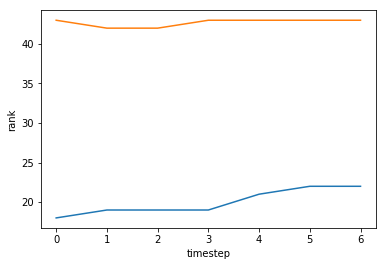


Application: Chart
Bug Nr:14

Number of Components
108

Faulty Component Ranking
rank: 18 org.jfree.chart.plot.CategoryPlot#2158
[774, 0.26919333213957247]
rank: 36 org.jfree.chart.plot.CategoryPlot#2436
[798, 0.24932944810224644]
rank: 50 org.jfree.chart.plot.XYPlot#2517
[807, 0.23462884116745175]
rank: 67 org.jfree.chart.plot.XYPlot#2285
[785, 0.21980526162240896]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 1 Avg Rank: 8 Worst Rank: 16org.jfree.chart.plot.CategoryPlot#2122
[774, 1.0]
Tarantula: Best rank: 1 Avg Rank: 8 Worst Rank: 16org.jfree.chart.util.LengthAdjustmentType#76
[785, 1.0]
Tarantula: Best rank: 1 Avg Rank: 8 Worst Rank: 16org.jfree.chart.plot.XYPlot#2481
[798, 1.0]
Tarantula: Best rank: 1 Avg Rank: 8 Worst Rank: 16org.jfree.chart.plot.PlotOrientation#57
[807, 1.0]
Ochiai: Best rank: 87 Avg Rank: 97 Worst Rank: 108org.jfree.chart.plot.Marker#534
[774, 0.022657162721472189]
Ochiai: Best rank: 87 Avg Rank: 97 Worst Rank: 108org.jfree.chart.ut

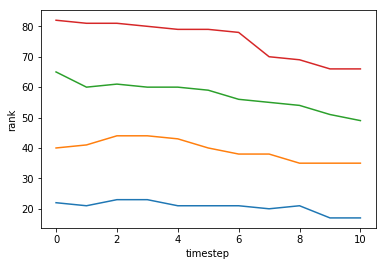


Application: Chart
Bug Nr:21

Number of Components
27

Faulty Component Ranking
rank: 2 org.jfree.data.statistics.DefaultBoxAndWhiskerCategoryDataset#740
[128, 0.65668794615611759]
rank: 7 org.jfree.data.statistics.DefaultBoxAndWhiskerCategoryDataset#147
[39, 0.37637503439647085]

Faulty Component Ranking for Tarantula and Ochiai
Ochiai: Best rank: 1 Avg Rank: 14 Worst Rank: 27org.jfree.data.Range#365
[128, 0.28867513459481292]
Tarantula: Best rank: 2 Avg Rank: 2 Worst Rank: 3org.jfree.data.statistics.DefaultBoxAndWhiskerCategoryDataset#740
[128, 0.92307692307692313]
Tarantula: Best rank: 8 Avg Rank: 13 Worst Rank: 19org.jfree.data.general.DatasetChangeEvent#73
[39, 0.54545454545454541]
Ochiai: Best rank: 1 Avg Rank: 14 Worst Rank: 27org.jfree.data.statistics.BoxAndWhiskerItem#223
[39, 0.28867513459481292]

Name of top 10 Ranking
org.jfree.data.Range#365
org.jfree.data.statistics.DefaultBoxAndWhiskerCategoryDataset#740
org.jfree.data.Range#330
org.jfree.data.statistics.BoxAndWhiskerIt

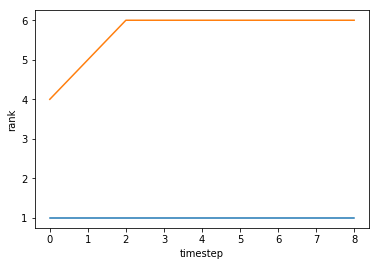


Application: Chart
Bug Nr:25

Number of Components
639

Faulty Component Ranking
rank: 6 org.jfree.chart.renderer.category.StatisticalBarRenderer#240
[744, 0.7221567954953354]
rank: 634 org.jfree.chart.renderer.category.StatisticalBarRenderer#383
[1016, 0.24175112885386857]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 1 Avg Rank: 5 Worst Rank: 9org.jfree.chart.axis.NumberAxis#1002
[744, 1.0]
Tarantula: Best rank: 601 Avg Rank: 606 Worst Rank: 612org.jfree.chart.util.StandardGradientPaintTransformer#79
[1016, 0.7142857142857143]
Ochiai: Best rank: 624 Avg Rank: 631 Worst Rank: 638org.jfree.chart.util.BooleanList#62
[744, 0.44721359549995793]
Ochiai: Best rank: 624 Avg Rank: 631 Worst Rank: 638org.jfree.chart.labels.ItemLabelAnchor#62
[1016, 0.44721359549995793]

Name of top 10 Ranking
org.jfree.chart.axis.NumberAxis#1176
org.jfree.chart.axis.CategoryAxis#1062
org.jfree.chart.axis.NumberAxis#1002
org.jfree.chart.axis.AxisState#130
org.jfree.chart.axis.ValueAx

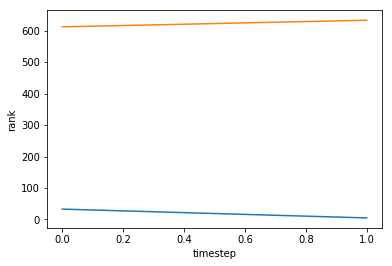


Application: Time
Bug Nr:1

Number of Components
414

Faulty Component Ranking
rank: 32 org.joda.time.field.UnsupportedDurationField#227
[594, 0.38066461911656452]
rank: 112 org.joda.time.Partial#190
[510, 0.36462617441933753]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 2 Avg Rank: 2 Worst Rank: 2org.joda.time.DateTimeUtils#88
[594, 0.95888399412628489]
Tarantula: Best rank: 149 Avg Rank: 149 Worst Rank: 149org.joda.time.chrono.BasicChronology$HalfdayField#759
[510, 0.47125330767380319]
Ochiai: Best rank: 371 Avg Rank: 392 Worst Rank: 414org.joda.time.chrono.ZonedChronology$ZonedDateTimeField#421
[510, 0.0030191783494250531]
Ochiai: Best rank: 371 Avg Rank: 392 Worst Rank: 414org.joda.time.tz.DateTimeZoneBuilder$PrecalculatedZone#1344
[594, 0.0030191783494250531]

Name of top 10 Ranking
org.joda.time.DateTimeUtils$FixedMillisProvider#556
org.joda.time.DateTimeUtils#88
org.joda.time.DateTimeZone#949
org.joda.time.DateTimeUtils#65
org.joda.time.tz.DateTimeZo

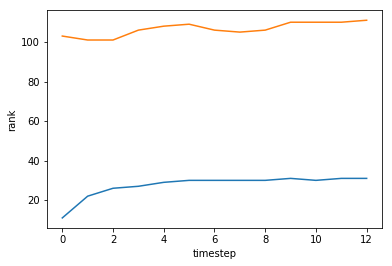


Application: Time
Bug Nr:3

Number of Components
572

Faulty Component Ranking
rank: 2 org.joda.time.MutableDateTime#785
[1191, 0.58949041060041696]
rank: 21 org.joda.time.MutableDateTime#636
[1106, 0.52377679384920317]
rank: 28 org.joda.time.MutableDateTime#764
[1175, 0.52045990355872174]
rank: 34 org.joda.time.MutableDateTime#702
[1139, 0.5175269311353482]
rank: 70 org.joda.time.MutableDateTime#660
[1119, 0.50921736208223967]
rank: 266 org.joda.time.MutableDateTime#723
[1150, 0.48587342014978624]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 1 Avg Rank: 1 Worst Rank: 1org.joda.time.base.BaseDateTime#61
[1191, 0.95810181708965303]
Tarantula: Best rank: 2 Avg Rank: 3 Worst Rank: 5org.joda.time.MutableDateTime#785
[1119, 0.95366218236173395]
Tarantula: Best rank: 2 Avg Rank: 3 Worst Rank: 5org.joda.time.DateTimeUtils$FixedMillisProvider#556
[1139, 0.95366218236173395]
Tarantula: Best rank: 2 Avg Rank: 3 Worst Rank: 5org.joda.time.chrono.ZonedChronology$ZonedD

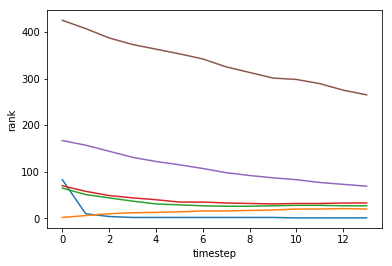


Application: Time
Bug Nr:5

Number of Components
448

Faulty Component Ranking
rank: 6 org.joda.time.Period#1617
[1195, 0.5287588210692723]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 11 Avg Rank: 11 Worst Rank: 12org.joda.time.DateTimeZone#175
[1195, 0.91437007874015752]
Ochiai: Best rank: 355 Avg Rank: 372 Worst Rank: 389org.joda.time.chrono.BasicChronology#747
[1195, 0.012924072956287579]

Name of top 10 Ranking
org.joda.time.DateTimeUtils#88
org.joda.time.DateTimeUtils$FixedMillisProvider#556
org.joda.time.DateTimeUtils#114
org.joda.time.DateTimeUtils#100
org.joda.time.DateTimeZone#949
org.joda.time.Period#1617
org.joda.time.DateTimeUtils$FixedMillisProvider#547
org.joda.time.DurationFieldType#141
org.joda.time.DateTimeFieldType$StandardDateTimeFieldType#444
org.joda.time.Period#444

Suspiciousness of top 10 Ranking
[204, 0.5967403111154852]
[952, 0.56380112059784937]
[322, 0.5538783996213722]
[265, 0.53977163613625001]
[1114, 0.52942796797167702]
[119

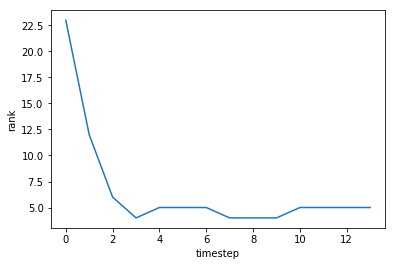


Application: Time
Bug Nr:9

Number of Components
188

Faulty Component Ranking
rank: 93 org.joda.time.DateTimeZone#255
[239, 0.24518912596645828]
rank: 125 org.joda.time.DateTimeZone#283
[272, 0.23332551373091218]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 16 Avg Rank: 16 Worst Rank: 16org.joda.time.chrono.BaseChronology#660
[239, 0.69297141829947873]
Tarantula: Best rank: 17 Avg Rank: 17 Worst Rank: 17org.joda.time.chrono.AssembledChronology#160
[272, 0.65976381995550226]
Ochiai: Best rank: 140 Avg Rank: 164 Worst Rank: 188org.joda.time.chrono.ISOChronology#133
[239, 0.0030437487004622583]
Ochiai: Best rank: 140 Avg Rank: 164 Worst Rank: 188org.joda.time.format.FormatUtils#31
[272, 0.0030437487004622583]

Name of top 10 Ranking
org.joda.time.DateTimeUtils$FixedMillisProvider#554
org.joda.time.DateTimeUtils#86
org.joda.time.DateTimeUtils$FixedMillisProvider#545
org.joda.time.tz.DateTimeZoneBuilder$DSTZone#1304
org.joda.time.DateTimeZone#1027
org.joda.time

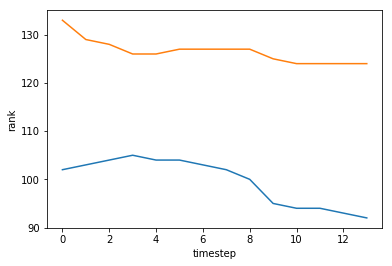


Application: Time
Bug Nr:18

Number of Components
461

Faulty Component Ranking
rank: 22 org.joda.time.chrono.GJChronology#356
[911, 0.50326465380595109]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 10 Avg Rank: 10 Worst Rank: 10org.joda.time.chrono.GJDayOfWeekDateTimeField#56
[911, 0.83491847826086962]
Ochiai: Best rank: 426 Avg Rank: 443 Worst Rank: 461org.joda.time.chrono.ISOChronology#77
[911, 0.0038817465764448963]

Name of top 10 Ranking
org.joda.time.DateTimeUtils$FixedMillisProvider#423
org.joda.time.DateTimeUtils#56
org.joda.time.base.BaseDateTime#61
org.joda.time.DateTimeUtils#82
org.joda.time.DateTimeZone#174
org.joda.time.DurationFieldType#105
org.joda.time.DateTimeUtils#129
org.joda.time.DateTimeFieldType#73
org.joda.time.chrono.BasicChronology#534
org.joda.time.chrono.GJDayOfWeekDateTimeField#56

Suspiciousness of top 10 Ranking
[966, 0.56290972905658521]
[66, 0.55926661379975684]
[90, 0.55654056951708275]
[181, 0.53355203055960454]
[540, 0.52

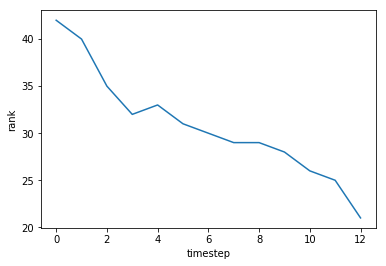


Application: Time
Bug Nr:21

Number of Components
399

Faulty Component Ranking
rank: 132 org.joda.time.tz.DefaultNameProvider#53
[53, 0.35855811441167068]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 4 Avg Rank: 4 Worst Rank: 4org.joda.time.DateTimeZone#174
[53, 0.94225458197338696]
Ochiai: Best rank: 349 Avg Rank: 352 Worst Rank: 356org.joda.time.field.DecoratedDateTimeField#82
[53, 0.0089406963464303355]

Name of top 10 Ranking
org.joda.time.DateTimeUtils$FixedMillisProvider#423
org.joda.time.DateTimeUtils#56
org.joda.time.DateTimeUtils#68
org.joda.time.DateTimeZone#174
org.joda.time.chrono.BasicMonthOfYearDateTimeField#92
org.joda.time.field.UnsupportedDurationField#49
org.joda.time.tz.DateTimeZoneBuilder$PrecalculatedZone#1509
org.joda.time.tz.DateTimeZoneBuilder$Recurrence#776
org.joda.time.tz.CachedDateTimeZone$Info#194
org.joda.time.field.RemainderDateTimeField#87

Suspiciousness of top 10 Ranking
[771, 0.43049213210511356]
[67, 0.42579430032291121]

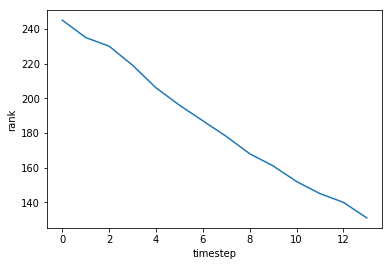


Application: Time
Bug Nr:23

Number of Components
132

Faulty Component Ranking
rank: 12 org.joda.time.DateTimeZone#559
[182, 0.4912496495824944]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 11 Avg Rank: 12 Worst Rank: 13org.joda.time.chrono.AssembledChronology#204
[182, 0.52472608824400346]
Ochiai: Best rank: 1 Avg Rank: 19 Worst Rank: 38org.joda.time.DateTimeZone#768
[182, 0.088885753644231055]

Name of top 10 Ranking
org.joda.time.DateTimeZone#1027
org.joda.time.DateTimeZone#174
org.joda.time.DateTimeZone#923
org.joda.time.tz.DateTimeZoneBuilder$PrecalculatedZone#1509
org.joda.time.chrono.AssembledChronology#284
org.joda.time.chrono.AssembledChronology#180
org.joda.time.chrono.BaseChronology#54
org.joda.time.chrono.ISOChronology#86
org.joda.time.chrono.AssembledChronology#172
org.joda.time.chrono.AssembledChronology#319

Suspiciousness of top 10 Ranking
[258, 0.52632682564541733]
[67, 0.5222867440897947]
[245, 0.51872462971586331]
[286, 0.512114869515714

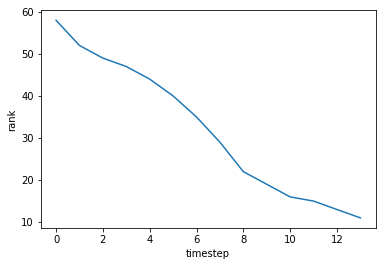


Application: Mockito
Bug Nr:1

Number of Components
441

Faulty Component Ranking
rank: 5 org.mockito.internal.invocation.InvocationMatcher#121
[774, 0.52781949177020238]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 105 Avg Rank: 105 Worst Rank: 105org.mockito.internal.invocation.InvocationsFinder$RemoveNotMatching#140
[774, 0.6834427425237054]
Ochiai: Best rank: 1 Avg Rank: 78 Worst Rank: 156org.mockito.internal.configuration.injection.ConstructorInjection#42
[774, 0.16975090042874999]

Name of top 10 Ranking
org.mockito.internal.util.collections.ArrayUtils#8
org.mockito.internal.util.collections.ArrayUtils#11
org.mockito.internal.matchers.ArrayEquals#67
org.mockito.internal.handler.InvocationNotifierHandler#58
org.mockito.internal.invocation.InvocationMatcher#121
org.mockito.internal.matchers.AnyVararg#19
org.mockito.internal.verification.checkers.NumberOfInvocationsChecker#34
org.mockito.Mockito#1256
org.mockito.internal.invocation.InvocationMatcher#98
o

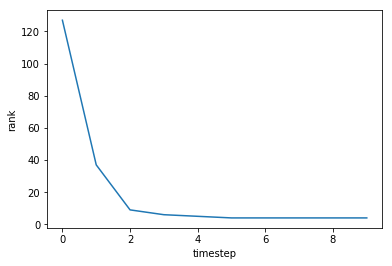


Application: Mockito
Bug Nr:2

Number of Components
184

Faulty Component Ranking
rank: 8 org.mockito.internal.util.Timer#7
[2, 0.6814174982974428]

Faulty Component Ranking for Tarantula and Ochiai
Ochiai: Best rank: 1 Avg Rank: 10 Worst Rank: 20org.mockito.Mockito#2017
[2, 0.39223227027636809]
Tarantula: Best rank: 13 Avg Rank: 13 Worst Rank: 13org.mockito.internal.verification.VerificationOverTimeImpl#123
[2, 0.66666666666666663]

Name of top 10 Ranking
org.mockito.Mockito#2038
org.mockito.internal.verification.VerificationModeFactory#13
org.mockito.Mockito#2017
org.mockito.internal.verification.VerificationModeFactory#17
org.mockito.verification.VerificationWrapper#29
org.mockito.verification.Timeout#25
org.mockito.verification.Timeout#44
org.mockito.internal.util.Timer#7
org.mockito.Mockito#2163
org.mockito.Mockito#1579

Suspiciousness of top 10 Ranking
[534, 0.77775424348554023]
[21, 0.76799779688131997]
[533, 0.75043006487309916]
[54, 0.72675914644738171]
[127, 0.71574132186552

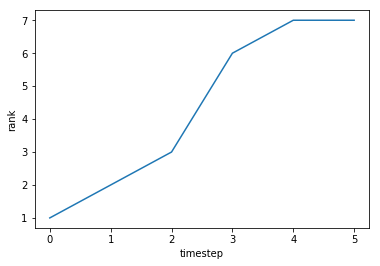


Application: Mockito
Bug Nr:3

Number of Components
369

Faulty Component Ranking
rank: 262 org.mockito.internal.invocation.InvocationMatcher#119
[879, 0.4080726962772292]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 88 Avg Rank: 88 Worst Rank: 88org.mockito.internal.matchers.MatchersPrinter#17
[879, 0.65138309965896179]
Ochiai: Best rank: 235 Avg Rank: 255 Worst Rank: 275org.mockito.Answers#76
[879, 0.092096011817397155]

Name of top 10 Ranking
org.mockito.internal.util.collections.ArrayUtils#11
org.mockito.internal.util.collections.ArrayUtils#8
org.mockito.internal.matchers.ArrayEquals#67
org.mockito.internal.matchers.CapturingMatcher#49
org.mockito.internal.util.collections.HashCodeAndEqualsSafeSet#67
org.mockito.Matchers#709
org.mockito.internal.matchers.CapturingMatcher#25
org.mockito.internal.handler.InvocationNotifierHandler#58
org.mockito.internal.util.collections.HashCodeAndEqualsMockWrapper#55
org.mockito.Matchers#270

Suspiciousness of top 10 Ran

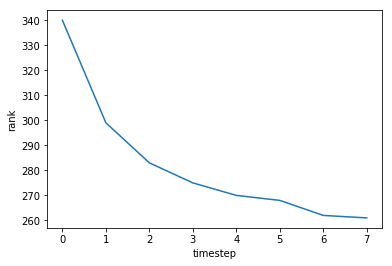


Application: Mockito
Bug Nr:4

Number of Components
329

Faulty Component Ranking
rank: 74 org.mockito.exceptions.Reporter#431
[696, 0.42716879771341731]
rank: 80 org.mockito.exceptions.Reporter#677
[740, 0.42558080873162774]
rank: 106 org.mockito.exceptions.Reporter#418
[694, 0.4200783288143633]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 1 Avg Rank: 1 Worst Rank: 2org.mockito.internal.invocation.MatchersBinder#23
[740, 1.0]
Tarantula: Best rank: 4 Avg Rank: 4 Worst Rank: 4org.mockito.internal.stubbing.BaseStubbing#14
[696, 0.98121712997746058]
Tarantula: Best rank: 6 Avg Rank: 6 Worst Rank: 6org.mockito.internal.MockitoCore#104
[694, 0.95258935083880381]
Ochiai: Best rank: 246 Avg Rank: 255 Worst Rank: 264org.mockito.internal.configuration.injection.PropertyAndSetterInjection#60
[694, 0.024749897520167742]
Ochiai: Best rank: 265 Avg Rank: 297 Worst Rank: 329org.mockito.internal.MockitoCore#84
[696, 0.012374948760083871]
Ochiai: Best rank: 265 Avg Rank: 2

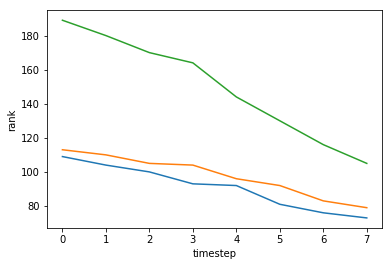


Application: Mockito
Bug Nr:6

Number of Components
399

Faulty Component Ranking
rank: 3 org.mockito.Matchers#339
[775, 0.50400245253802689]
rank: 12 org.mockito.Matchers#197
[744, 0.49313589653314965]
rank: 27 org.mockito.Matchers#167
[732, 0.48423180068644178]
rank: 28 org.mockito.Matchers#407
[791, 0.48388901355056385]
rank: 33 org.mockito.Matchers#137
[694, 0.48267635110237633]
rank: 77 org.mockito.Matchers#244
[757, 0.47150639533968708]
rank: 84 org.mockito.Matchers#373
[783, 0.47046099873290953]
rank: 131 org.mockito.Matchers#442
[797, 0.46074663336876565]
rank: 133 org.mockito.Matchers#212
[747, 0.46065974676423438]
rank: 134 org.mockito.Matchers#227
[753, 0.46063627225759934]
rank: 153 org.mockito.Matchers#122
[668, 0.45855833433596976]
rank: 185 org.mockito.Matchers#152
[715, 0.45523768951599225]
rank: 205 org.mockito.Matchers#324
[773, 0.4517523549008266]
rank: 228 org.mockito.Matchers#182
[739, 0.44759774870595304]

Faulty Component Ranking for Tarantula and Ochiai
Tarantu

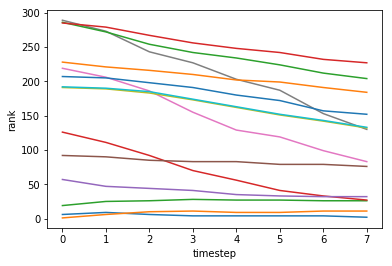


Application: Mockito
Bug Nr:7

Number of Components
247

Faulty Component Ranking
rank: 14 org.mockito.internal.util.reflection.GenericMetadataSupport$TypeVariableReturnType#376
[573, 0.38258681179101089]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 10 Avg Rank: 12 Worst Rank: 14org.mockito.internal.util.reflection.GenericMetadataSupport$TypeVariableReturnType#372
[573, 0.77966101694915257]
Ochiai: Best rank: 1 Avg Rank: 124 Worst Rank: 247org.mockito.internal.handler.InvocationNotifierHandler#81
[573, 0.14744195615489714]

Name of top 10 Ranking
org.mockito.internal.handler.InvocationNotifierHandler#59
org.mockito.exceptions.base.MockitoException#34
org.mockito.internal.util.reflection.GenericMetadataSupport$TypeVariableReturnType#430
org.mockito.internal.configuration.GlobalConfiguration#59
org.mockito.exceptions.base.MockitoException#39
org.mockito.internal.util.reflection.GenericMetadataSupport$TypeVariableReturnType#412
org.mockito.internal.util.reflec

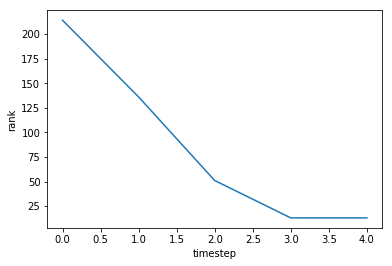


Application: Mockito
Bug Nr:8

Number of Components
16

Faulty Component Ranking
rank: 11 org.mockito.internal.util.reflection.GenericMetadataSupport#67
[8, 0.11359024787094657]

Faulty Component Ranking for Tarantula and Ochiai
Ochiai: Best rank: 1 Avg Rank: 8 Worst Rank: 16org.mockito.internal.util.reflection.GenericMetadataSupport$TypeVariableReturnType#376
[8, 0.14907119849998599]
Tarantula: Best rank: 13 Avg Rank: 14 Worst Rank: 15org.mockito.internal.util.reflection.GenericMetadataSupport#56
[8, 0.51136363636363635]

Name of top 10 Ranking
org.mockito.internal.util.reflection.GenericMetadataSupport$TypeVariableReturnType#362
org.mockito.internal.util.reflection.GenericMetadataSupport$TypeVariableReturnType#372
org.mockito.internal.util.reflection.GenericMetadataSupport#182
org.mockito.internal.util.reflection.GenericMetadataSupport$TypeVarBoundedType#519
org.mockito.internal.util.reflection.GenericMetadataSupport$TypeVariableReturnType#376
org.mockito.internal.util.reflection.Ge

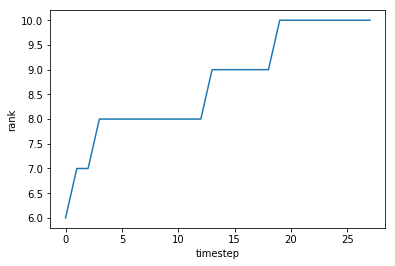


Application: Mockito
Bug Nr:9

Number of Components
305

Faulty Component Ranking
rank: 1 org.mockito.internal.stubbing.answers.CallsRealMethods#36
[227, 0.4764490601093368]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 11 Avg Rank: 11 Worst Rank: 11org.mockito.internal.stubbing.InvocationContainerImpl#40
[227, 0.94610091743119262]
Ochiai: Best rank: 229 Avg Rank: 233 Worst Rank: 237org.mockito.internal.configuration.injection.MockInjectionStrategy#41
[227, 0.045226701686664539]

Name of top 10 Ranking
org.mockito.internal.stubbing.answers.CallsRealMethods#36
org.mockito.internal.handler.NullResultGuardian#29
org.mockito.internal.handler.MockHandlerImpl#48
org.mockito.exceptions.Reporter#583
org.mockito.internal.creation.cglib.MethodInterceptorFilter#71
org.mockito.internal.creation.DelegatingMethod#12
org.mockito.internal.stubbing.InvocationContainerImpl#99
org.mockito.internal.util.ObjectMethodsGuru#34
org.mockito.internal.invocation.ArgumentsProcessor#22


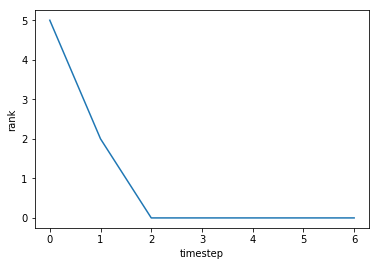


Application: Mockito
Bug Nr:10

Number of Components
260

Faulty Component Ranking
rank: 72 org.mockito.internal.stubbing.defaultanswers.ReturnsDeepStubs#95
[386, 0.47402349648022946]
rank: 74 org.mockito.internal.stubbing.defaultanswers.ReturnsDeepStubs#59
[283, 0.47352809650421829]
rank: 204 org.mockito.internal.stubbing.defaultanswers.ReturnsDeepStubs#88
[373, 0.43505412914393643]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 8 Avg Rank: 10 Worst Rank: 13org.mockito.internal.creation.DelegatingMethod#16
[283, 0.95377777777777784]
Tarantula: Best rank: 8 Avg Rank: 10 Worst Rank: 13org.mockito.internal.creation.DelegatingMethod#26
[373, 0.95377777777777784]
Tarantula: Best rank: 8 Avg Rank: 10 Worst Rank: 13org.mockito.internal.stubbing.InvocationContainerImpl#77
[386, 0.95377777777777784]
Ochiai: Best rank: 179 Avg Rank: 219 Worst Rank: 260org.mockito.internal.configuration.ClassPathLoader#97
[283, 0.021586644588817278]
Ochiai: Best rank: 179 Avg Rank: 219

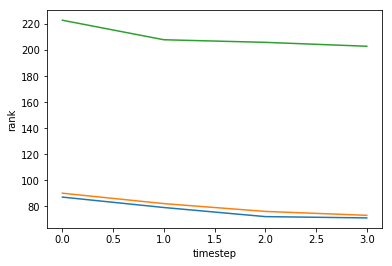


Application: Mockito
Bug Nr:11

Number of Components
132

Faulty Component Ranking
rank: 19 org.mockito.internal.creation.DelegatingMethod#55
[159, 0.46757519134885833]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 1 Avg Rank: 1 Worst Rank: 1org.mockito.MockitoAnnotations#121
[159, 0.99501936912008848]
Ochiai: Best rank: 97 Avg Rank: 97 Worst Rank: 97org.mockito.internal.util.Checks#14
[159, 0.038511419125246672]

Name of top 10 Ranking
org.mockito.MockitoAnnotations#121
org.mockito.internal.util.MockUtil#69
org.mockito.internal.configuration.InjectingAnnotationEngine#23
org.mockito.internal.configuration.injection.MockInjectionStrategy#41
org.mockito.MockitoAnnotations#138
org.mockito.internal.creation.DelegatingMethod#12
org.mockito.internal.configuration.injection.filter.FinalMockCandidateFilter#22
org.mockito.internal.configuration.injection.MockInjection$OngoingMockInjection#71
org.mockito.internal.util.MockUtil#65
org.mockito.internal.configuration.Def

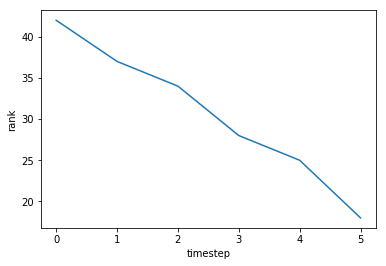


Application: Mockito
Bug Nr:12

Number of Components
107

Faulty Component Ranking
rank: 22 org.mockito.internal.util.reflection.GenericMaster#17
[69, 0.26588294568837456]

Faulty Component Ranking for Tarantula and Ochiai
Ochiai: Best rank: 1 Avg Rank: 1 Worst Rank: 2org.mockito.internal.progress.HandyReturnValues#17
[69, 1.0]
Tarantula: Best rank: 20 Avg Rank: 20 Worst Rank: 21org.mockito.internal.util.reflection.GenericMaster#8
[69, 0.58823529411764708]

Name of top 10 Ranking
org.mockito.internal.creation.jmock.ClassImposterizer#117
org.mockito.internal.progress.HandyReturnValues#17
org.mockito.internal.configuration.DefaultAnnotationEngine#70
org.mockito.internal.stubbing.defaultanswers.ReturnsEmptyValues#51
org.mockito.internal.util.MockCreationValidator#11
org.mockito.ArgumentCaptor#45
org.mockito.ArgumentMatcher#57
org.mockito.internal.matchers.CapturingMatcher#16
org.mockito.internal.util.MockUtil#26
org.mockito.ArgumentCaptor#123

Suspiciousness of top 10 Ranking
[419, 0.994

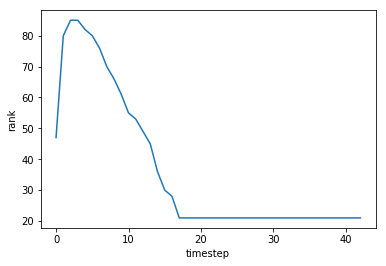


Application: Mockito
Bug Nr:13

Number of Components
263

Faulty Component Ranking
rank: 180 org.mockito.internal.MockHandler#59
[325, 0.4548913160774205]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 128 Avg Rank: 128 Worst Rank: 128org.mockito.internal.debugging.Location#17
[325, 0.58814229249011862]
Ochiai: Best rank: 1 Avg Rank: 92 Worst Rank: 184org.mockito.internal.stubbing.BaseStubbing#15
[325, 0.051847584736521263]

Name of top 10 Ranking
org.mockito.Mockito#1502
org.mockito.internal.invocation.InvocationMatcher#93
org.mockito.internal.progress.MockingProgressImpl#33
org.mockito.internal.stubbing.defaultanswers.ReturnsEmptyValues#59
org.mockito.internal.verification.MockAwareVerificationMode#22
org.mockito.internal.creation.DelegatingMethod#25
org.mockito.internal.MockitoCore#51
org.mockito.internal.invocation.ArgumentsComparator#21
org.mockito.internal.stubbing.defaultanswers.ReturnsEmptyValues#74
org.mockito.internal.progress.ThreadSafeMockingProgr

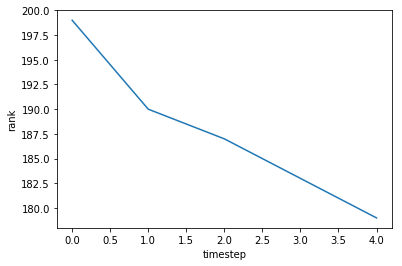


Application: Mockito
Bug Nr:14

Number of Components
224

Faulty Component Ranking
rank: 13 org.mockito.internal.MockHandler#58
[285, 0.51451434972688181]
rank: 176 org.mockito.internal.MockitoCore#68
[313, 0.45141641275885414]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 49 Avg Rank: 49 Worst Rank: 50org.mockito.internal.configuration.DefaultAnnotationEngine#80
[313, 0.70764762826718286]
Tarantula: Best rank: 112 Avg Rank: 112 Worst Rank: 112org.mockito.internal.stubbing.InvocationContainerImpl#54
[285, 0.58620689655172409]
Ochiai: Best rank: 1 Avg Rank: 112 Worst Rank: 224org.mockito.exceptions.Reporter#245
[285, 0.036986336072765455]
Ochiai: Best rank: 1 Avg Rank: 112 Worst Rank: 224org.mockito.internal.util.MockUtil#92
[313, 0.036986336072765455]

Name of top 10 Ranking
org.mockito.internal.MockitoCore#63
org.mockito.internal.stubbing.ConsecutiveStubbing#14
org.mockito.internal.stubbing.defaultanswers.ReturnsEmptyValues#74
org.mockito.internal.stubbing.

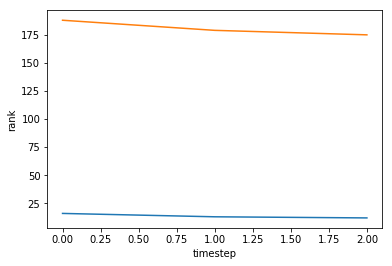


Application: Mockito
Bug Nr:15

Number of Components
163

Faulty Component Ranking
rank: 40 org.mockito.internal.configuration.injection.FinalMockCandidateFilter#19
[59, 0.49555781865682491]

Faulty Component Ranking for Tarantula and Ochiai
Ochiai: Best rank: 1 Avg Rank: 82 Worst Rank: 163org.mockito.internal.configuration.DefaultAnnotationEngine#35
[59, 0.21320071635561041]
Tarantula: Best rank: 40 Avg Rank: 53 Worst Rank: 66org.mockito.internal.progress.ArgumentMatcherStorageImpl#100
[59, 0.51162790697674421]

Name of top 10 Ranking
org.mockito.internal.creation.MethodInterceptorFilter#51
org.mockito.internal.util.MockUtil#84
org.mockito.internal.util.MockUtil#104
org.mockito.internal.MockHandler#116
org.mockito.internal.util.reflection.FieldInitializer#91
org.mockito.internal.util.MockUtil#72
org.mockito.internal.util.reflection.FieldInitializer#85
org.mockito.internal.util.reflection.FieldInitializer#60
org.mockito.internal.util.MockUtil#92
org.mockito.internal.util.reflection.Fi

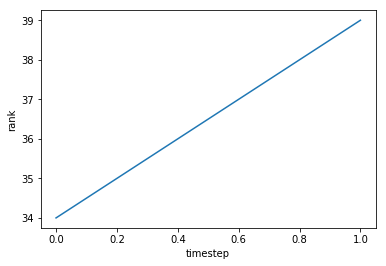


Application: Mockito
Bug Nr:16

Number of Components
162

Faulty Component Ranking
rank: 61 org.mockito.internal.MockitoCore#34
[158, 0.47945661863665062]
rank: 136 org.mockito.Mockito#827
[454, 0.43268969989460015]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 82 Avg Rank: 82 Worst Rank: 82org.mockito.internal.MockitoCore#26
[454, 0.51828298887122415]
Ochiai: Best rank: 1 Avg Rank: 81 Worst Rank: 162org.mockito.internal.debugging.Location#17
[158, 0.039163022499397869]
Tarantula: Best rank: 108 Avg Rank: 111 Worst Rank: 114org.mockito.internal.debugging.Location#20
[158, 0.50858034321372858]
Ochiai: Best rank: 1 Avg Rank: 81 Worst Rank: 162org.mockito.internal.progress.ArgumentMatcherStorageImpl#100
[454, 0.039163022499397869]

Name of top 10 Ranking
org.mockito.internal.progress.MockingProgressImpl#107
org.mockito.internal.creation.MockSettingsImpl#72
org.mockito.internal.progress.ThreadSafeMockingProgress#30
org.mockito.internal.stubbing.defaultanswers.Re

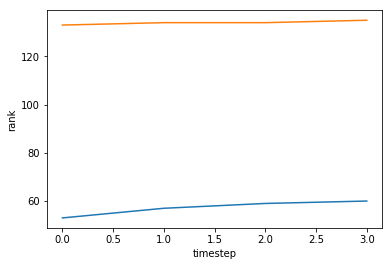


Application: Mockito
Bug Nr:17

Number of Components
83

Faulty Component Ranking
rank: 36 org.mockito.internal.creation.MockSettingsImpl#22
[60, 0.46176082269818208]
rank: 71 org.mockito.internal.util.MockUtil#34
[107, 0.40424914669517986]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 1 Avg Rank: 1 Worst Rank: 1org.mockito.internal.invocation.MatchersBinder#15
[60, 0.97181008902077148]
Tarantula: Best rank: 36 Avg Rank: 36 Worst Rank: 37org.mockito.internal.MockitoCore#26
[107, 0.51092043681747279]
Ochiai: Best rank: 1 Avg Rank: 42 Worst Rank: 83org.mockito.internal.configuration.ClassPathLoader#10
[60, 0.039073233258228181]
Ochiai: Best rank: 1 Avg Rank: 42 Worst Rank: 83org.mockito.internal.creation.jmock.ClassImposterizer#58
[107, 0.039073233258228181]

Name of top 10 Ranking
org.mockito.internal.invocation.MatchersBinder#15
org.mockito.internal.creation.jmock.ClassImposterizer#44
org.mockito.internal.creation.jmock.ClassImposterizer#21
org.mockito.inter

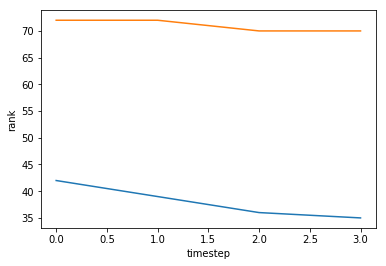


Application: Mockito
Bug Nr:18

Number of Components
138

Faulty Component Ranking
rank: 22 org.mockito.internal.stubbing.defaultanswers.ReturnsEmptyValues#83
[226, 0.45967655319740286]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 1 Avg Rank: 1 Worst Rank: 1org.mockito.internal.configuration.injection.scanner.MockScanner#86
[226, 0.66248506571087218]
Ochiai: Best rank: 1 Avg Rank: 53 Worst Rank: 106org.mockito.internal.progress.MockingProgressImpl#30
[226, 0.042466769483558583]

Name of top 10 Ranking
org.mockito.internal.configuration.injection.scanner.MockScanner#86
org.mockito.MockitoAnnotations#121
org.mockito.internal.configuration.injection.MockInjection$OngoingMockInjection#86
org.mockito.configuration.DefaultMockitoConfiguration#39
org.mockito.internal.util.Primitives#42
org.mockito.internal.configuration.injection.scanner.InjectMocksScanner#29
org.mockito.internal.util.collections.HashCodeAndEqualsSafeSet#132
org.mockito.internal.progress.ThreadSaf

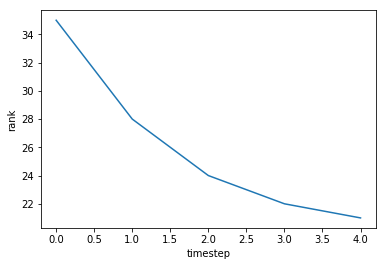


Application: Mockito
Bug Nr:19

Number of Components
301

Faulty Component Ranking
rank: 3 org.mockito.internal.configuration.injection.filter.TypeBasedCandidateFilter#21
[100, 0.51300379224081738]
rank: 48 org.mockito.internal.configuration.injection.filter.NameBasedCandidateFilter#24
[120, 0.49385051142909087]
rank: 132 org.mockito.internal.configuration.injection.filter.FinalMockCandidateFilter#24
[118, 0.47725252640187749]
rank: 205 org.mockito.internal.configuration.injection.PropertyAndSetterInjection#112
[433, 0.45647436764952276]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 19 Avg Rank: 20 Worst Rank: 21org.mockito.internal.configuration.injection.ConstructorInjection$SimpleArgumentResolver#72
[100, 0.96247960848287117]
Tarantula: Best rank: 19 Avg Rank: 20 Worst Rank: 21org.mockito.internal.exceptions.stacktrace.DefaultStackTraceCleaner#8
[118, 0.96247960848287117]
Tarantula: Best rank: 19 Avg Rank: 20 Worst Rank: 21org.mockito.internal.exceptions.

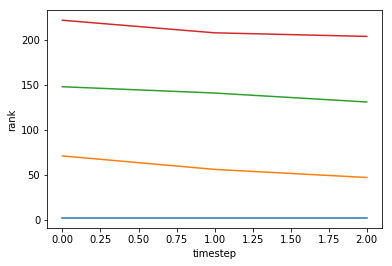


Application: Mockito
Bug Nr:20

Number of Components
328

Faulty Component Ranking
rank: 220 org.mockito.internal.creation.bytebuddy.ByteBuddyMockMaker#25
[169, 0.40115997031210548]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 28 Avg Rank: 46 Worst Rank: 64org.mockito.internal.creation.settings.CreationSettings#64
[169, 0.55531732418524871]
Ochiai: Best rank: 1 Avg Rank: 89 Worst Rank: 177org.mockito.internal.util.MockNameImpl#18
[169, 0.078597749189185925]

Name of top 10 Ranking
org.mockito.internal.creation.bytebuddy.InterceptedInvocation$SuperMethod$FromCallable#178
org.mockito.internal.creation.bytebuddy.InterceptedInvocation$SuperMethod$FromCallable#184
org.mockito.internal.creation.bytebuddy.InterceptedInvocation#118
org.mockito.internal.stubbing.answers.CallsRealMethods#39
org.mockito.internal.creation.MockSettingsImpl#98
org.mockito.internal.creation.bytebuddy.InterceptedInvocation$SuperMethod$FromCallable#172
org.mockito.internal.creation.MockSett

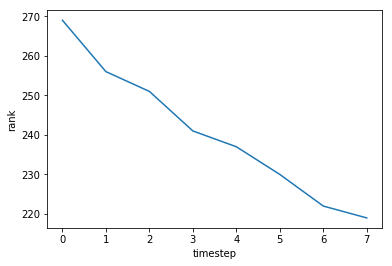


Application: Mockito
Bug Nr:21

Number of Components
92

Faulty Component Ranking
rank: 1 org.mockito.internal.creation.instance.ConstructorInstantiator#24
[69, 0.65460245108531823]
rank: 5 org.mockito.internal.creation.instance.ConstructorInstantiator#14
[8, 0.59147057321070118]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 2 Avg Rank: 2 Worst Rank: 2org.mockito.internal.creation.instance.InstantationException#6
[69, 0.88888888888888884]
Ochiai: Best rank: 1 Avg Rank: 46 Worst Rank: 92org.mockito.internal.creation.instance.ConstructorInstantiator#9
[8, 0.25]
Tarantula: Best rank: 4 Avg Rank: 4 Worst Rank: 5org.mockito.internal.creation.instance.ConstructorInstantiator#14
[8, 0.61538461538461542]
Ochiai: Best rank: 1 Avg Rank: 46 Worst Rank: 92org.mockito.internal.configuration.injection.PropertyAndSetterInjection#59
[69, 0.25]

Name of top 10 Ranking
org.mockito.internal.creation.instance.ConstructorInstantiator#24
org.mockito.internal.creation.instance.Ins

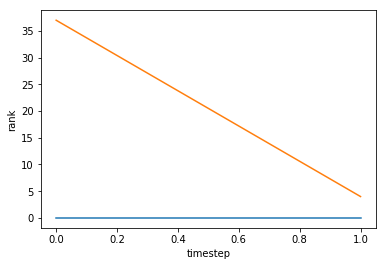


Application: Mockito
Bug Nr:22

Number of Components
127

Faulty Component Ranking
rank: 3 org.mockito.internal.matchers.Equality#13
[6, 0.52669939442122116]

Faulty Component Ranking for Tarantula and Ochiai
Ochiai: Best rank: 1 Avg Rank: 42 Worst Rank: 84org.mockito.internal.util.collections.HashCodeAndEqualsSafeSet$1#45
[6, 0.059496411730872965]
Tarantula: Best rank: 7 Avg Rank: 7 Worst Rank: 7org.mockito.internal.configuration.GlobalConfiguration#59
[6, 0.68072289156626498]

Name of top 10 Ranking
org.mockito.internal.configuration.injection.ConstructorInjection#42
org.mockito.internal.util.collections.HashCodeAndEqualsSafeSet$1#45
org.mockito.internal.matchers.Equality#13
org.mockito.internal.configuration.SpyAnnotationEngine#47
org.mockito.internal.configuration.InjectingAnnotationEngine#60
org.mockito.internal.matchers.Equality#32
org.mockito.internal.configuration.GlobalConfiguration#59
org.mockito.internal.configuration.injection.MockInjection#48
org.mockito.internal.util.col

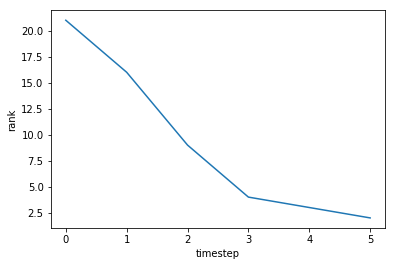


Application: Mockito
Bug Nr:23

Number of Components
309

Faulty Component Ranking
rank: 102 org.mockito.internal.stubbing.defaultanswers.ReturnsDeepStubs#48
[251, 0.45532486578036008]
rank: 202 org.mockito.internal.stubbing.defaultanswers.ReturnsDeepStubs#114
[443, 0.43227920780527945]
rank: 238 org.mockito.internal.stubbing.defaultanswers.ReturnsDeepStubs#94
[405, 0.42348428804416033]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 12 Avg Rank: 14 Worst Rank: 16org.mockito.internal.invocation.ArgumentsProcessor#42
[405, 0.93783783783783781]
Tarantula: Best rank: 12 Avg Rank: 14 Worst Rank: 16org.mockito.internal.creation.MethodInterceptorFilter#65
[443, 0.93783783783783781]
Tarantula: Best rank: 17 Avg Rank: 21 Worst Rank: 25org.mockito.internal.creation.MethodInterceptorFilter#73
[251, 0.93530997304582209]
Ochiai: Best rank: 208 Avg Rank: 258 Worst Rank: 309org.mockito.internal.progress.MockingProgressImpl#35
[251, 0.017894270903167298]
Ochiai: Best rank: 2

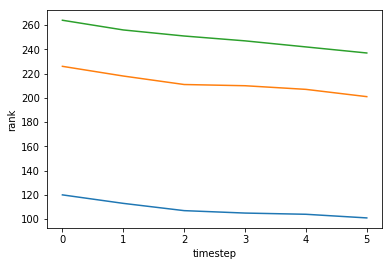


Application: Mockito
Bug Nr:24

Number of Components
378

Faulty Component Ranking
rank: 23 org.mockito.internal.stubbing.defaultanswers.ReturnsEmptyValues#64
[701, 0.44311861263849822]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 84 Avg Rank: 84 Worst Rank: 84org.mockito.internal.configuration.SpyAnnotationEngine#47
[701, 0.59165256627185558]
Ochiai: Best rank: 222 Avg Rank: 233 Worst Rank: 245org.mockito.internal.handler.InvocationNotifierHandler#38
[701, 0.046313064082082883]

Name of top 10 Ranking
org.mockito.internal.stubbing.StubberImpl#53
org.mockito.internal.handler.InvocationNotifierHandler#49
org.mockito.internal.creation.DelegatingMethod#15
org.mockito.exceptions.Reporter#376
org.mockito.internal.stubbing.answers.ThrowsException#34
org.mockito.internal.creation.AcrossJVMSerializationFeature#62
org.mockito.internal.creation.DelegatingMockitoMethodProxy#13
org.mockito.internal.creation.DelegatingMethod#41
org.mockito.internal.stubbing.StubbedInvoc

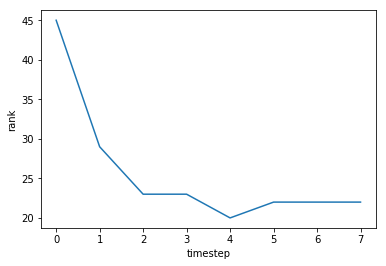


Application: Mockito
Bug Nr:25

Number of Components
376

Faulty Component Ranking
rank: 4 org.mockito.internal.stubbing.defaultanswers.ReturnsDeepStubs#45
[553, 0.48783983915711482]
rank: 25 org.mockito.internal.stubbing.defaultanswers.ReturnsDeepStubs#57
[656, 0.47815939531926827]
rank: 37 org.mockito.internal.stubbing.defaultanswers.ReturnsDeepStubs#82
[797, 0.47465082620206311]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 17 Avg Rank: 18 Worst Rank: 19org.mockito.internal.creation.cglib.CGLIBHacker#37
[656, 0.98099952099632759]
Tarantula: Best rank: 17 Avg Rank: 18 Worst Rank: 19org.mockito.internal.progress.MockingProgressImpl#94
[797, 0.98099952099632759]
Tarantula: Best rank: 20 Avg Rank: 24 Worst Rank: 28org.mockito.internal.handler.InvocationNotifierHandler#69
[553, 0.97990430622009572]
Ochiai: Best rank: 175 Avg Rank: 191 Worst Rank: 208org.mockito.internal.invocation.InvocationImpl#97
[553, 0.070868338689230106]
Ochiai: Best rank: 175 Avg Rank: 1

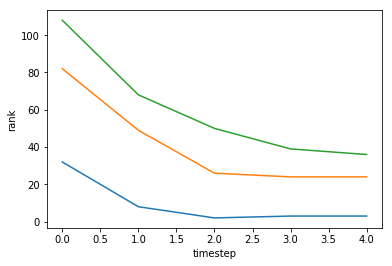


Application: Mockito
Bug Nr:27

Number of Components
247

Faulty Component Ranking
rank: 108 org.mockito.internal.util.MockUtil#63
[305, 0.43715156261497329]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 8 Avg Rank: 9 Worst Rank: 10org.mockito.internal.util.Primitives#27
[305, 0.94200351493848866]
Ochiai: Best rank: 190 Avg Rank: 218 Worst Rank: 247org.mockito.internal.creation.jmock.ClassImposterizer#112
[305, 0.017633640396464957]

Name of top 10 Ranking
org.mockito.internal.MockHandler#52
org.mockito.internal.verification.VerificationDataImpl#29
org.mockito.internal.InvocationNotifierHandler#58
org.mockito.internal.creation.DelegatingMockitoMethodProxy#14
org.mockito.internal.invocation.InvocationMatcher#42
org.mockito.exceptions.Reporter#312
org.mockito.internal.progress.MockingProgressImpl#40
org.mockito.internal.verification.checkers.MissingInvocationChecker#32
org.mockito.internal.util.Primitives#27
org.mockito.internal.creation.DelegatingMethod#38

S

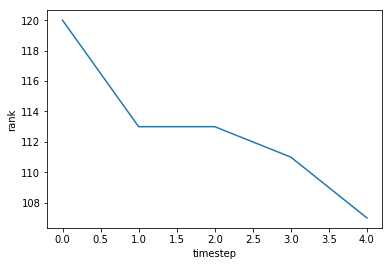


Application: Mockito
Bug Nr:28

Number of Components
191

Faulty Component Ranking
rank: 178 org.mockito.internal.configuration.DefaultInjectionEngine#92
[274, 0.41815042065485447]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 63 Avg Rank: 79 Worst Rank: 96org.mockito.internal.util.MockUtil#26
[274, 0.50943396226415094]
Ochiai: Best rank: 1 Avg Rank: 96 Worst Rank: 191org.mockito.internal.creation.jmock.ClassImposterizer$3#73
[274, 0.19245008972987526]

Name of top 10 Ranking
org.mockito.internal.creation.MockSettingsImpl#45
org.mockito.internal.util.MockName#36
org.mockito.internal.progress.ArgumentMatcherStorageImpl#38
org.mockito.internal.MockHandler#59
org.mockito.internal.util.MockName#41
org.mockito.internal.creation.cglib.CGLIBHacker#19
org.mockito.internal.progress.MockingProgressImpl#52
org.mockito.internal.progress.ThreadSafeMockingProgress#68
org.mockito.internal.creation.MockSettingsImpl#72
org.mockito.internal.MockitoCore#146

Suspiciousness of 

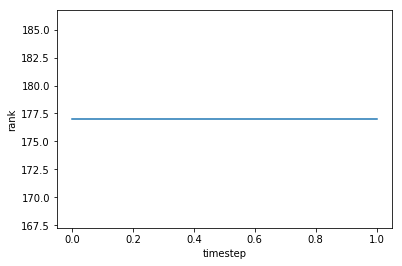


Application: Mockito
Bug Nr:29

Number of Components
228

Faulty Component Ranking
rank: 5 org.mockito.internal.matchers.Same#27
[160, 0.53882687943604302]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 5 Avg Rank: 7 Worst Rank: 10org.mockito.internal.invocation.Invocation#98
[160, 0.93442622950819676]
Ochiai: Best rank: 1 Avg Rank: 114 Worst Rank: 228org.mockito.internal.verification.VerificationDataImpl#32
[160, 0.13245323570650439]

Name of top 10 Ranking
org.mockito.internal.verification.argumentmatching.ArgumentMatchingTool#21
org.mockito.internal.verification.argumentmatching.ArgumentMatchingTool#48
org.mockito.internal.verification.argumentmatching.ArgumentMatchingTool#15
org.mockito.internal.progress.ThreadSafeMockingProgress#60
org.mockito.internal.matchers.Same#27
org.mockito.MockitoAnnotations#134
org.mockito.internal.invocation.Invocation#98
org.mockito.internal.invocation.InvocationsFinder#65
org.mockito.internal.util.reflection.FieldSetter#14
or

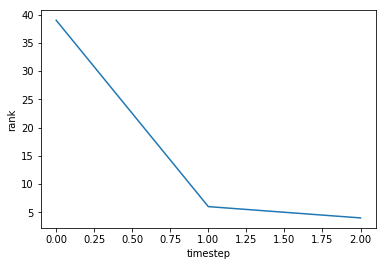


Application: Mockito
Bug Nr:30

Number of Components
125

Faulty Component Ranking
rank: 1 org.mockito.exceptions.Reporter#439
[253, 0.51160775385741697]
rank: 83 org.mockito.internal.stubbing.defaultanswers.ReturnsSmartNulls$ThrowingInterceptor#52
[127, 0.42498036736048922]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 1 Avg Rank: 1 Worst Rank: 2org.mockito.exceptions.verification.SmartNullPointerException#14
[253, 0.98989898989898994]
Tarantula: Best rank: 5 Avg Rank: 5 Worst Rank: 6org.mockito.internal.util.ObjectMethodsGuru#18
[127, 0.9819639278557114]
Ochiai: Best rank: 76 Avg Rank: 100 Worst Rank: 125org.mockito.internal.progress.MockingProgressImpl#48
[127, 0.022587697572631283]
Ochiai: Best rank: 76 Avg Rank: 100 Worst Rank: 125org.mockito.internal.progress.MockingProgressImpl#80
[253, 0.022587697572631283]

Name of top 10 Ranking
org.mockito.exceptions.Reporter#439
org.mockito.exceptions.verification.SmartNullPointerException#14
org.mockito.internal

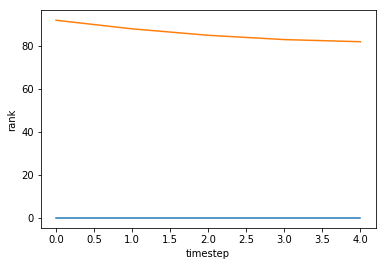


Application: Mockito
Bug Nr:31

Number of Components
121

Faulty Component Ranking
rank: 73 org.mockito.internal.stubbing.defaultanswers.ReturnsSmartNulls$ThrowingInterceptor#60
[137, 0.44661702804725217]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 1 Avg Rank: 1 Worst Rank: 1org.mockito.internal.creation.DelegatingMethod#29
[137, 0.99236641221374045]
Ochiai: Best rank: 70 Avg Rank: 95 Worst Rank: 121org.mockito.internal.progress.ArgumentMatcherStorageImpl#100
[137, 0.025318484177091666]

Name of top 10 Ranking
org.mockito.internal.creation.DelegatingMethod#29
org.mockito.internal.stubbing.defaultanswers.ReturnsEmptyValues#64
org.mockito.exceptions.base.MockitoAssertionError#17
org.mockito.internal.creation.DelegatingMethod#33
org.mockito.exceptions.verification.WantedButNotInvoked#15
org.mockito.internal.stubbing.defaultanswers.ReturnsEmptyValues#84
org.mockito.internal.stubbing.defaultanswers.ReturnsMoreEmptyValues#66
org.mockito.internal.invocation.Invoc

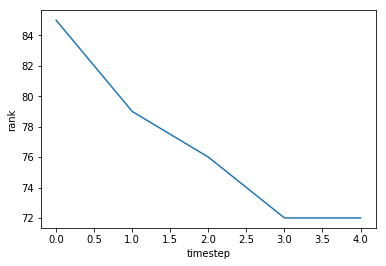


Application: Mockito
Bug Nr:32

Number of Components
272

Faulty Component Ranking
rank: 264 org.mockito.internal.configuration.SpyAnnotationEngine#29
[173, 0.39045351696413394]

Faulty Component Ranking for Tarantula and Ochiai
Ochiai: Best rank: 1 Avg Rank: 102 Worst Rank: 204org.mockito.internal.creation.AbstractMockitoMethodProxy#7
[173, 0.045810870835137615]
Tarantula: Best rank: 244 Avg Rank: 245 Worst Rank: 246org.mockito.internal.invocation.MatchersBinder#28
[173, 0.50026246719160106]

Name of top 10 Ranking
org.mockito.internal.reporting.PrintSettings#11
org.mockito.internal.invocation.InvocationsFinder#18
org.mockito.exceptions.base.MockitoAssertionError#17
org.mockito.internal.invocation.Invocation#98
org.mockito.internal.util.ListUtil#13
org.mockito.internal.reporting.SmartPrinter#28
org.mockito.internal.creation.MockSettingsImpl#57
org.mockito.internal.invocation.InvocationMatcher#49
org.mockito.internal.stubbing.InvocationContainerImpl#42
org.mockito.internal.util.Object

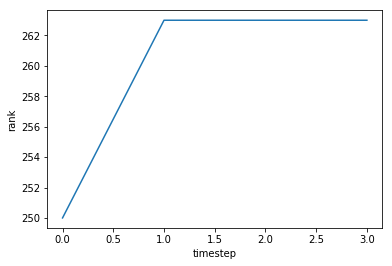


Application: Mockito
Bug Nr:33

Number of Components
257

Faulty Component Ranking
rank: 68 org.mockito.internal.invocation.InvocationMatcher#95
[359, 0.49264408486747346]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 46 Avg Rank: 46 Worst Rank: 46org.mockito.internal.progress.MockingProgressImpl#39
[359, 0.61614349775784749]
Ochiai: Best rank: 1 Avg Rank: 76 Worst Rank: 152org.mockito.internal.debugging.Localized#13
[359, 0.066081860045508978]

Name of top 10 Ranking
org.mockito.internal.verification.checkers.NumberOfInvocationsChecker#24
org.mockito.internal.invocation.Invocation#129
org.mockito.internal.invocation.InvocationsFinder#18
org.mockito.configuration.DefaultMockitoConfiguration#32
org.mockito.exceptions.Reporter#248
org.mockito.internal.invocation.InvocationMatcher#53
org.mockito.Mockito#1515
org.mockito.internal.invocation.InvocationMatcher#45
org.mockito.internal.stubbing.BaseStubbing#15
org.mockito.internal.stubbing.defaultanswers.ReturnsEmpt

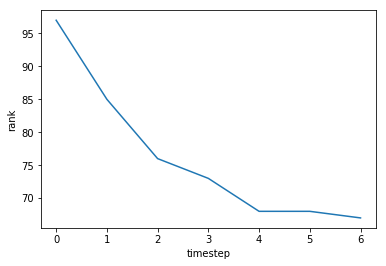


Application: Mockito
Bug Nr:34

Number of Components
208

Faulty Component Ranking
rank: 58 org.mockito.internal.invocation.InvocationMatcher#104
[591, 0.48934860159871457]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 43 Avg Rank: 43 Worst Rank: 43org.mockito.internal.util.ObjectMethodsGuru#27
[591, 0.65909090909090917]
Ochiai: Best rank: 1 Avg Rank: 76 Worst Rank: 152org.mockito.internal.invocation.realmethod.CGLIBProxyRealMethod#17
[591, 0.057306825506125279]

Name of top 10 Ranking
org.mockito.Matchers#221
org.mockito.internal.progress.MockingProgressImpl#32
org.mockito.internal.stubbing.answers.Returns#34
org.mockito.internal.invocation.Invocation#94
org.mockito.internal.debugging.DebuggingInfo#40
org.mockito.ArgumentMatcher#57
org.mockito.internal.stubbing.ConsecutiveStubbing#14
org.mockito.internal.invocation.Invocation#203
org.mockito.internal.stubbing.defaultanswers.ReturnsEmptyValues#59
org.mockito.internal.stubbing.StubbedInvocationMatcher#20

Sus

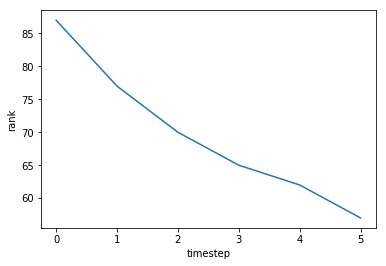


Application: Mockito
Bug Nr:35

Number of Components
170

Faulty Component Ranking
rank: 8 org.mockito.Matchers#362
[460, 0.52665400959604802]
rank: 51 org.mockito.Matchers#516
[484, 0.48807514276385044]
rank: 78 org.mockito.Matchers#479
[482, 0.46905388545346671]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 1 Avg Rank: 1 Worst Rank: 2org.mockito.internal.progress.ArgumentMatcherStorageImpl#30
[484, 0.98742138364779874]
Tarantula: Best rank: 3 Avg Rank: 3 Worst Rank: 3org.mockito.internal.progress.ThreadSafeMockingProgress#58
[460, 0.98124999999999996]
Tarantula: Best rank: 6 Avg Rank: 6 Worst Rank: 6org.mockito.internal.stubbing.defaultanswers.ReturnsEmptyValues#113
[482, 0.91812865497076024]
Ochiai: Best rank: 164 Avg Rank: 164 Worst Rank: 165org.mockito.internal.configuration.GlobalConfiguration#52
[460, 0.039904344223381107]
Ochiai: Best rank: 166 Avg Rank: 168 Worst Rank: 170org.mockito.internal.configuration.GlobalConfiguration#19
[482, 0.019952172111

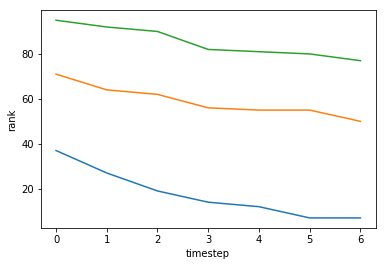


Application: Mockito
Bug Nr:36

Number of Components
181

Faulty Component Ranking
rank: 5 org.mockito.internal.invocation.Invocation#202
[635, 0.4870900586190256]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 1 Avg Rank: 1 Worst Rank: 1org.mockito.internal.debugging.DebuggingInfo#23
[635, 0.96510228640192541]
Ochiai: Best rank: 1 Avg Rank: 46 Worst Rank: 92org.mockito.internal.stubbing.MockitoStubber#80
[635, 0.049937616943892232]

Name of top 10 Ranking
org.mockito.internal.debugging.DebuggingInfo#23
org.mockito.internal.progress.MockingProgressImpl#32
org.mockito.internal.invocation.Invocation#150
org.mockito.internal.progress.ThreadSafeMockingProgress#42
org.mockito.internal.invocation.Invocation#202
org.mockito.internal.stubbing.MockitoStubber#45
org.mockito.internal.verification.RegisteredInvocations#27
org.mockito.internal.creation.jmock.ClassImposterizer$2#39
org.mockito.internal.stubbing.defaultanswers.ReturnsSmartNulls#37
org.mockito.internal.debug

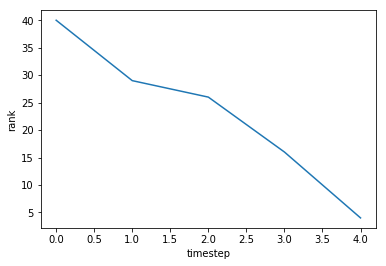


Application: Mockito
Bug Nr:37

Number of Components
161

Faulty Component Ranking
rank: 7 org.mockito.internal.stubbing.answers.AnswersValidator#16
[55, 0.50350481597641594]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 4 Avg Rank: 4 Worst Rank: 5org.mockito.internal.verification.RegisteredInvocations#27
[55, 0.61680327868852458]
Ochiai: Best rank: 1 Avg Rank: 47 Worst Rank: 93org.mockito.internal.invocation.Invocation#150
[55, 0.081513914593922238]

Name of top 10 Ranking
org.mockito.internal.stubbing.answers.AnswersValidator#11
org.mockito.internal.exceptions.base.StackTraceFilter#15
org.mockito.Mockito#731
org.mockito.internal.exceptions.base.StackTraceFilter#29
org.mockito.internal.verification.RegisteredInvocations#27
org.mockito.internal.stubbing.defaultanswers.ReturnsEmptyValues#73
org.mockito.internal.stubbing.answers.AnswersValidator#16
org.mockito.internal.stubbing.BaseStubbing#49
org.mockito.internal.creation.cglib.MockitoNamingPolicy#15
org.mock

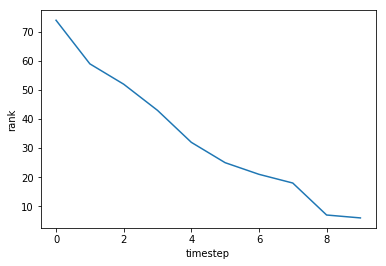


Application: Mockito
Bug Nr:38

Number of Components
208

Faulty Component Ranking
rank: 4 org.mockito.internal.verification.argumentmatching.ArgumentMatchingTool#48
[254, 0.56343954778185934]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 4 Avg Rank: 4 Worst Rank: 4org.mockito.internal.verification.argumentmatching.ArgumentMatchingTool#48
[254, 0.78125]
Ochiai: Best rank: 1 Avg Rank: 17 Worst Rank: 33org.mockito.internal.progress.ThreadSafeMockingProgress#31
[254, 0.1414213562373095]

Name of top 10 Ranking
org.mockito.internal.matchers.Equals#31
org.mockito.internal.matchers.Any#13
org.mockito.Matchers#202
org.mockito.internal.verification.argumentmatching.ArgumentMatchingTool#48
org.mockito.internal.verification.argumentmatching.ArgumentMatchingTool#41
org.mockito.internal.invocation.InvocationMatcher#83
org.mockito.internal.matchers.Equals#42
org.mockito.internal.MockitoCore#43
org.mockito.Mockito#941
org.mockito.internal.matchers.Equals#20

Suspiciousnes

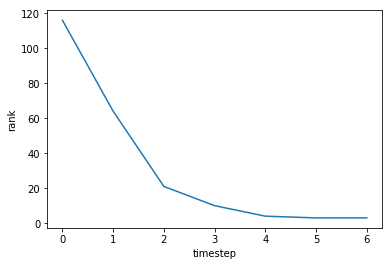


Application: Lang
Bug Nr:30

Number of Components
11

Faulty Component Ranking
rank: 1 org.apache.commons.lang3.StringUtils#1674
[111, 0.1381058791632826]
rank: 3 org.apache.commons.lang3.StringUtils#1372
[90, 0.071736411159885147]
rank: 6 org.apache.commons.lang3.StringUtils#1444
[96, 0.043208916058557784]
rank: 8 org.apache.commons.lang3.StringUtils#1570
[104, 0.029314361480796611]
rank: 10 org.apache.commons.lang3.StringUtils#1498
[99, 0.02218983045108645]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 2 Avg Rank: 3 Worst Rank: 5org.apache.commons.lang3.ArrayUtils#3279
[104, 0.97578692493946739]
Tarantula: Best rank: 2 Avg Rank: 3 Worst Rank: 5org.apache.commons.lang3.StringUtils#1372
[111, 0.97578692493946739]
Tarantula: Best rank: 2 Avg Rank: 3 Worst Rank: 5org.apache.commons.lang3.StringUtils#1715
[90, 0.97578692493946739]
Ochiai: Best rank: 4 Avg Rank: 4 Worst Rank: 4org.apache.commons.lang3.StringUtils#1715
[111, 0.063009708181057583]
Ochiai: Best ran

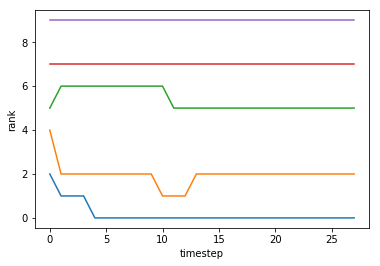


Application: Lang
Bug Nr:32

Number of Components
19

Faulty Component Ranking
rank: 8 org.apache.commons.lang3.builder.HashCodeBuilder#538
[37, 0.18429592634462125]
rank: 11 org.apache.commons.lang3.builder.HashCodeBuilder#173
[10, 0.17102233689937041]
rank: 15 org.apache.commons.lang3.builder.HashCodeBuilder#522
[35, 0.14722868236510053]
rank: 18 org.apache.commons.lang3.builder.HashCodeBuilder#104
[4, 0.0352631713111696]

Faulty Component Ranking for Tarantula and Ochiai
Ochiai: Best rank: 1 Avg Rank: 10 Worst Rank: 19org.apache.commons.lang3.builder.IDKey#40
[4, 0.15075567228888181]
Tarantula: Best rank: 2 Avg Rank: 8 Worst Rank: 14org.apache.commons.lang3.builder.HashCodeBuilder#538
[35, 0.86274509803921562]
Ochiai: Best rank: 1 Avg Rank: 10 Worst Rank: 19org.apache.commons.lang3.builder.HashCodeBuilder#538
[35, 0.15075567228888181]
Tarantula: Best rank: 2 Avg Rank: 8 Worst Rank: 14org.apache.commons.lang3.ArrayUtils#55
[37, 0.86274509803921562]
Ochiai: Best rank: 1 Avg Rank: 10 

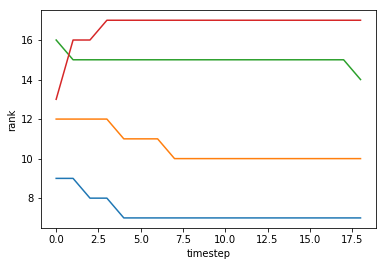


Application: Lang
Bug Nr:36

Number of Components
22

Faulty Component Ranking
rank: 3 org.apache.commons.lang3.math.NumberUtils#449
[26, 0.18788573361687061]
rank: 16 org.apache.commons.lang3.math.NumberUtils#1313
[95, 0.081240637859747528]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 1 Avg Rank: 1 Worst Rank: 1org.apache.commons.lang3.math.NumberUtils#628
[95, 1.0]
Tarantula: Best rank: 2 Avg Rank: 5 Worst Rank: 8org.apache.commons.lang3.math.NumberUtils#710
[26, 0.984375]
Ochiai: Best rank: 1 Avg Rank: 6 Worst Rank: 12org.apache.commons.lang3.StringUtils#191
[26, 0.17817416127494959]
Ochiai: Best rank: 13 Avg Rank: 17 Worst Rank: 22org.apache.commons.lang3.math.NumberUtils#41
[95, 0.089087080637474794]

Name of top 10 Ranking
org.apache.commons.lang3.math.NumberUtils#628
org.apache.commons.lang3.math.NumberUtils#710
org.apache.commons.lang3.math.NumberUtils#449
org.apache.commons.lang3.StringUtils#191
org.apache.commons.lang3.math.NumberUtils#694
org.apa

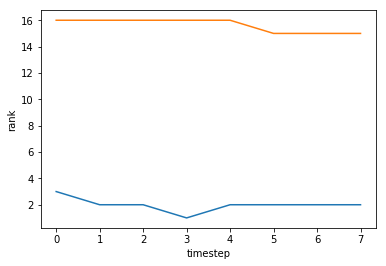


Application: Lang
Bug Nr:63

Number of Components
12

Faulty Component Ranking
rank: 2 org.apache.commons.lang.time.DurationFormatUtils#265
[13, 0.53223998133868888]
rank: 3 org.apache.commons.lang.time.DurationFormatUtils#433
[21, 0.38495290175537367]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 2 Avg Rank: 2 Worst Rank: 3org.apache.commons.lang.time.DurationFormatUtils#265
[13, 0.84615384615384615]
Tarantula: Best rank: 2 Avg Rank: 2 Worst Rank: 3org.apache.commons.lang.time.DurationFormatUtils#433
[21, 0.84615384615384615]
Ochiai: Best rank: 1 Avg Rank: 6 Worst Rank: 12org.apache.commons.lang.StringUtils#3865
[13, 0.30151134457776363]
Ochiai: Best rank: 1 Avg Rank: 6 Worst Rank: 12org.apache.commons.lang.time.DurationFormatUtils$Token#566
[21, 0.30151134457776363]

Name of top 10 Ranking
org.apache.commons.lang.time.DurationFormatUtils#247
org.apache.commons.lang.time.DurationFormatUtils#265
org.apache.commons.lang.time.DurationFormatUtils#433
org.apache

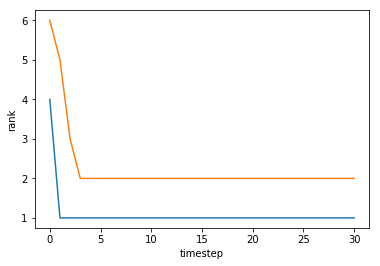


Application: Math
Bug Nr:6

Number of Components
414

Faulty Component Ranking
rank: 43 org.apache.commons.math3.optim.nonlinear.scalar.noderiv.PowellOptimizer#174
[455, 0.36727163876785179]
rank: 99 org.apache.commons.math3.optim.nonlinear.scalar.noderiv.CMAESOptimizer#370
[717, 0.35244771228099658]
rank: 131 org.apache.commons.math3.optim.nonlinear.scalar.noderiv.SimplexOptimizer#128
[369, 0.34608754480854942]
rank: 149 org.apache.commons.math3.optim.nonlinear.vector.jacobian.LevenbergMarquardtOptimizer#285
[624, 0.34365079482126126]
rank: 260 org.apache.commons.math3.optim.nonlinear.scalar.gradient.NonLinearConjugateGradientOptimizer#193
[489, 0.32569731757923642]
rank: 278 org.apache.commons.math3.optim.nonlinear.vector.jacobian.GaussNewtonOptimizer#81
[223, 0.32380081563481744]
rank: 412 org.apache.commons.math3.optim.BaseOptimizer#47
[60, 0.24118242817220603]

Faulty Component Ranking for Tarantula and Ochiai
Ochiai: Best rank: 1 Avg Rank: 12 Worst Rank: 24org.apache.commons.mat

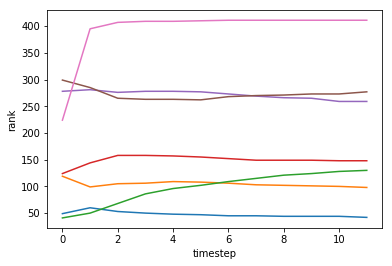


Application: Math
Bug Nr:8

Number of Components
22

Faulty Component Ranking
rank: 2 org.apache.commons.math3.distribution.DiscreteDistribution#182
[111, 0.71964509518553255]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 1 Avg Rank: 1 Worst Rank: 2org.apache.commons.math3.distribution.DiscreteDistribution#182
[111, 1.0]
Ochiai: Best rank: 1 Avg Rank: 11 Worst Rank: 22org.apache.commons.math3.util.Pair#45
[111, 0.21821789023599239]

Name of top 10 Ranking
org.apache.commons.math3.distribution.DiscreteDistribution#69
org.apache.commons.math3.distribution.DiscreteDistribution#182
org.apache.commons.math3.distribution.DiscreteDistribution#157
org.apache.commons.math3.random.BitsStreamGenerator#90
org.apache.commons.math3.random.Well19937c#86
org.apache.commons.math3.distribution.DiscreteRealDistribution#66
org.apache.commons.math3.distribution.AbstractRealDistribution#50
org.apache.commons.math3.distribution.DiscreteDistribution#86
org.apache.commons.math3.rand

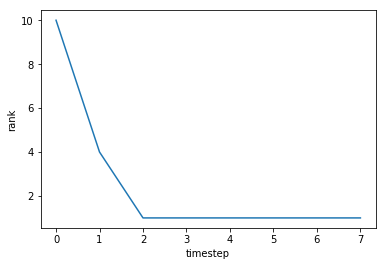


Application: Math
Bug Nr:16

Number of Components
65

Faulty Component Ranking
rank: 50 org.apache.commons.math3.util.FastMath#384
[58, 0.06070495898384775]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 1 Avg Rank: 1 Worst Rank: 1org.apache.commons.math3.random.MersenneTwister#216
[58, 0.99076048329779676]
Ochiai: Best rank: 1 Avg Rank: 33 Worst Rank: 65org.apache.commons.math3.dfp.Dfp#781
[58, 0.026783579200279007]

Name of top 10 Ranking
org.apache.commons.math3.random.MersenneTwister#216
org.apache.commons.math3.dfp.Dfp#1231
org.apache.commons.math3.dfp.DfpField#736
org.apache.commons.math3.dfp.DfpField#530
org.apache.commons.math3.dfp.Dfp#202
org.apache.commons.math3.dfp.DfpField$RoundingMode#30
org.apache.commons.math3.dfp.DfpField#578
org.apache.commons.math3.dfp.Dfp$1#1087
org.apache.commons.math3.dfp.Dfp#1895
org.apache.commons.math3.dfp.Dfp#1683

Suspiciousness of top 10 Ranking
[38, 0.10049654248903411]
[142, 0.098946963553354916]
[105, 0.098937067

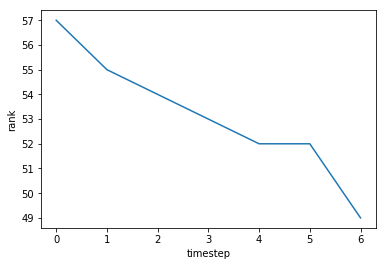


Application: Math
Bug Nr:38

Number of Components
56

Faulty Component Ranking
rank: 12 org.apache.commons.math.optimization.direct.BOBYQAOptimizer#1584
[657, 0.48867936981707832]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 4 Avg Rank: 19 Worst Rank: 34org.apache.commons.math.optimization.direct.BaseAbstractMultivariateOptimizer#132
[657, 0.55172413793103448]
Ochiai: Best rank: 1 Avg Rank: 28 Worst Rank: 56org.apache.commons.math.optimization.direct.BOBYQAOptimizer#287
[657, 0.25]

Name of top 10 Ranking
org.apache.commons.math.optimization.direct.BOBYQAOptimizer#2454
org.apache.commons.math.optimization.direct.BOBYQAOptimizer$PathIsExploredException#2479
org.apache.commons.math.util.CompositeFormat#54
org.apache.commons.math.linear.Array2DRowRealMatrix#301
org.apache.commons.math.optimization.direct.BOBYQAOptimizer#235
org.apache.commons.math.util.Incrementor#109
org.apache.commons.math.linear.ArrayRealVector#83
org.apache.commons.math.optimization.direct

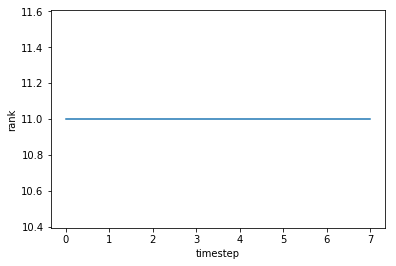


Application: Math
Bug Nr:51

Number of Components
55

Faulty Component Ranking
rank: 46 org.apache.commons.math.analysis.solvers.BaseSecantSolver#130
[88, 0.36431193507622334]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 20 Avg Rank: 30 Worst Rank: 40org.apache.commons.math.analysis.solvers.BaseAbstractUnivariateRealSolver#294
[88, 0.53030303030303028]
Ochiai: Best rank: 1 Avg Rank: 28 Worst Rank: 55org.apache.commons.math.analysis.solvers.BaseAbstractUnivariateRealSolver#128
[88, 0.1690308509457033]

Name of top 10 Ranking
org.apache.commons.math.exception.MaxCountExceededException#53
org.apache.commons.math.exception.MathIllegalStateException#72
org.apache.commons.math.exception.MaxCountExceededException#42
org.apache.commons.math.exception.MathIllegalStateException#84
org.apache.commons.math.exception.MathIllegalStateException#36
org.apache.commons.math.analysis.solvers.RegulaFalsiSolver#43
org.apache.commons.math.exception.TooManyEvaluationsException#37

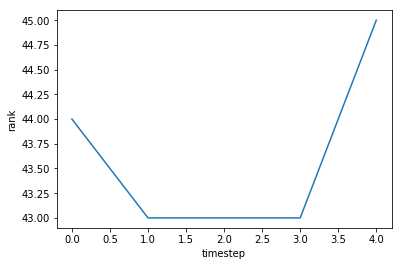


Application: Math
Bug Nr:64

Number of Components
24

Faulty Component Ranking
rank: 10 org.apache.commons.math.optimization.general.LevenbergMarquardtOptimizer#245
[92, 0.36052322965001826]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 7 Avg Rank: 7 Worst Rank: 8org.apache.commons.math.optimization.general.AbstractLeastSquaresOptimizer#124
[92, 0.51485148514851486]
Ochiai: Best rank: 1 Avg Rank: 12 Worst Rank: 24org.apache.commons.math.optimization.general.LevenbergMarquardtOptimizer#212
[92, 0.19611613513818404]

Name of top 10 Ranking
org.apache.commons.math.optimization.general.LevenbergMarquardtOptimizer#662
org.apache.commons.math.optimization.general.AbstractLeastSquaresOptimizer#250
org.apache.commons.math.optimization.general.AbstractLeastSquaresOptimizer#240
org.apache.commons.math.optimization.VectorialPointValuePair#81
org.apache.commons.math.optimization.general.LevenbergMarquardtOptimizer#493
org.apache.commons.math.optimization.general.Levenbe

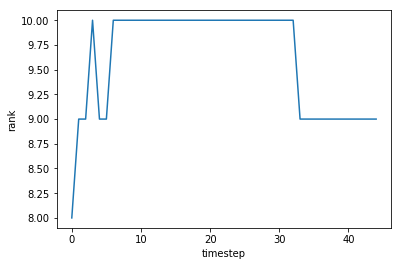


Application: Math
Bug Nr:66

Number of Components
79

Faulty Component Ranking
rank: 47 org.apache.commons.math.optimization.univariate.BrentOptimizer#66
[51, 0.49084805585478786]
rank: 61 org.apache.commons.math.optimization.univariate.BrentOptimizer#60
[36, 0.45504410863114014]
rank: 67 org.apache.commons.math.optimization.univariate.BrentOptimizer#99
[127, 0.42227705407694349]
rank: 77 org.apache.commons.math.optimization.univariate.BrentOptimizer#43
[13, 0.35280815440874769]

Faulty Component Ranking for Tarantula and Ochiai
Ochiai: Best rank: 1 Avg Rank: 9 Worst Rank: 17org.apache.commons.math.exception.MathIllegalArgumentException#56
[13, 0.81649658092772615]
Ochiai: Best rank: 1 Avg Rank: 9 Worst Rank: 17org.apache.commons.math.optimization.MultiStartUnivariateRealOptimizer#219
[36, 0.81649658092772615]
Ochiai: Best rank: 1 Avg Rank: 9 Worst Rank: 17org.apache.commons.math.optimization.MultiStartUnivariateRealOptimizer#193
[127, 0.81649658092772615]
Ochiai: Best rank: 18 Avg Ra

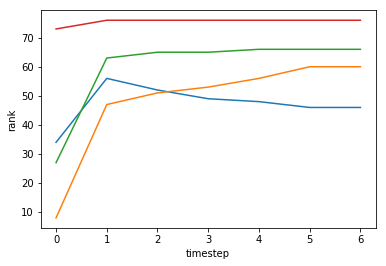


Application: Math
Bug Nr:71

Number of Components
73

Faulty Component Ranking
rank: 46 org.apache.commons.math.ode.nonstiff.RungeKuttaIntegrator#100
[65, 0.34188444393436296]
rank: 60 org.apache.commons.math.ode.nonstiff.EmbeddedRungeKuttaIntegrator#197
[135, 0.31258663235269679]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 43 Avg Rank: 43 Worst Rank: 43org.apache.commons.math.ode.events.EventState$1#214
[65, 0.5436893203883495]
Ochiai: Best rank: 52 Avg Rank: 62 Worst Rank: 73org.apache.commons.math.ode.nonstiff.AdaptiveStepsizeIntegrator#93
[135, 0.066815310478106099]
Tarantula: Best rank: 68 Avg Rank: 68 Worst Rank: 68org.apache.commons.math.ode.sampling.AbstractStepInterpolator#89
[135, 0.4869565217391304]
Ochiai: Best rank: 52 Avg Rank: 62 Worst Rank: 73org.apache.commons.math.ode.sampling.AbstractStepInterpolator#89
[65, 0.066815310478106099]

Name of top 10 Ranking
org.apache.commons.math.ode.sampling.DummyStepInterpolator#107
org.apache.commons.mat

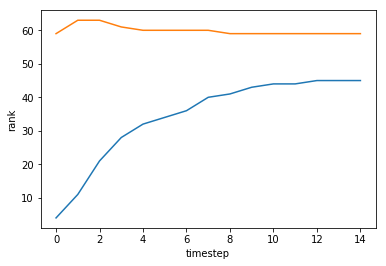


Application: Closure
Bug Nr:3

Number of Components
1089

Faulty Component Ranking
rank: 171 com.google.javascript.jscomp.FlowSensitiveInlineVariables$Candidate#282
[1629, 0.48516555363712743]
rank: 753 com.google.javascript.jscomp.FlowSensitiveInlineVariables#127
[837, 0.4644634526479004]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 67 Avg Rank: 68 Worst Rank: 69com.google.javascript.rhino.jstype.PrototypeObjectType#287
[1629, 0.83726415094339623]
Tarantula: Best rank: 187 Avg Rank: 190 Worst Rank: 193com.google.javascript.jscomp.parsing.IRFactory$TransformDispatcher#571
[837, 0.66355140186915884]
Ochiai: Best rank: 1 Avg Rank: 538 Worst Rank: 1076com.google.javascript.jscomp.graph.LinkedDirectedGraph#107
[837, 0.091927711955384336]
Ochiai: Best rank: 1 Avg Rank: 538 Worst Rank: 1076com.google.javascript.rhino.Node#1373
[1629, 0.091927711955384336]

Name of top 10 Ranking
com.google.javascript.rhino.Node#112
com.google.javascript.rhino.Node#934
com.google.

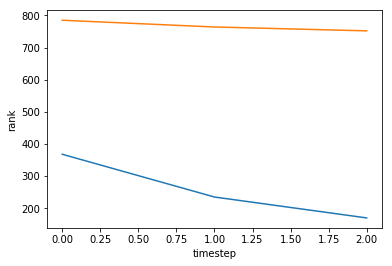


Application: Closure
Bug Nr:16

Number of Components
1751

Faulty Component Ranking
rank: 9 com.google.javascript.jscomp.ScopedAliases$Traversal#458
[2461, 0.49297505631808292]
rank: 51 com.google.javascript.jscomp.ScopedAliases$AliasedTypeNode#173
[1245, 0.48618929522151366]
rank: 220 com.google.javascript.jscomp.ScopedAliases$AliasedTypeNode#180
[1289, 0.4801610495005697]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 49 Avg Rank: 50 Worst Rank: 52com.google.javascript.jscomp.ScopedAliases$Traversal#367
[1245, 0.96039603960396036]
Tarantula: Best rank: 49 Avg Rank: 50 Worst Rank: 52com.google.javascript.jscomp.ScopedAliases$AliasedTypeNode#173
[1289, 0.96039603960396036]
Tarantula: Best rank: 49 Avg Rank: 50 Worst Rank: 52com.google.javascript.jscomp.parsing.JsDocInfoParser#117
[2461, 0.96039603960396036]
Ochiai: Best rank: 1 Avg Rank: 358 Worst Rank: 716com.google.javascript.rhino.Node$StringNode#235
[1245, 0.071795815861773818]
Ochiai: Best rank: 1 Avg Ra

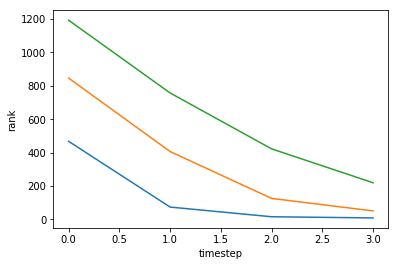


Application: Closure
Bug Nr:26

Number of Components
1940

Faulty Component Ranking
rank: 9 com.google.javascript.jscomp.ProcessCommonJSModules$ProcessCommonJsModulesCallback#208
[1714, 0.49222885762420321]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 1 Avg Rank: 4 Worst Rank: 7com.google.javascript.jscomp.MaybeReachingVariableUse$ReachingUses#102
[1714, 0.999691548426897]
Ochiai: Best rank: 1 Avg Rank: 329 Worst Rank: 658com.google.javascript.jscomp.CompilerOptions$TweakProcessing#1987
[1714, 0.032862038995038749]

Name of top 10 Ranking
com.google.javascript.rhino.Node#598
com.google.javascript.jscomp.ProcessCommonJSModules$ProcessCommonJsModulesCallback#124
com.google.javascript.jscomp.PeepholeSubstituteAlternateSyntax#629
com.google.javascript.jscomp.ControlFlowAnalysis$AstControlFlowGraph$2#1038
com.google.javascript.jscomp.MaybeReachingVariableUse$ReachingUses#102
com.google.javascript.jscomp.AbstractCommandLineRunner#1293
com.google.javascript.jscomp

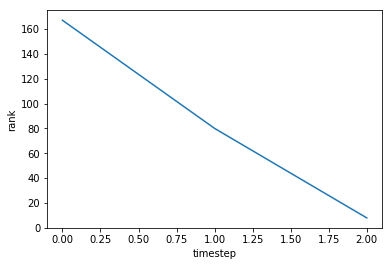


Application: Closure
Bug Nr:27

Number of Components
17

Faulty Component Ranking
rank: 2 com.google.javascript.rhino.IR#224
[37, 0.46372976221696732]
rank: 7 com.google.javascript.rhino.IR#231
[39, 0.35057628800805479]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 1 Avg Rank: 2 Worst Rank: 4com.google.javascript.rhino.IR#239
[37, 1.0]
Tarantula: Best rank: 1 Avg Rank: 2 Worst Rank: 4com.google.javascript.rhino.IR#224
[39, 1.0]
Ochiai: Best rank: 4 Avg Rank: 9 Worst Rank: 14com.google.javascript.rhino.IR#97
[39, 0.013955677373644389]
Ochiai: Best rank: 15 Avg Rank: 16 Worst Rank: 17com.google.javascript.rhino.Node#2297
[37, 0.0069778386868221947]

Name of top 10 Ranking
com.google.javascript.rhino.IR#239
com.google.javascript.rhino.IR#224
com.google.javascript.rhino.IR#293
com.google.javascript.rhino.Node#2205
com.google.javascript.rhino.IR#97
com.google.javascript.rhino.IR#474
com.google.javascript.rhino.IR#231
com.google.javascript.rhino.Node#2293
com.goog

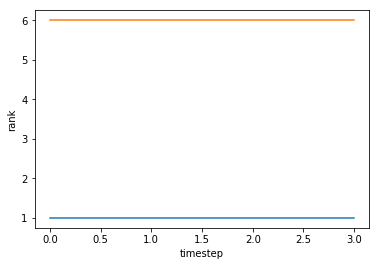


Application: Closure
Bug Nr:37

Number of Components
540

Faulty Component Ranking
rank: 120 com.google.javascript.jscomp.NodeTraversal#511
[2245, 0.47417046391006384]
rank: 369 com.google.javascript.jscomp.parsing.IRFactory$TransformDispatcher#611
[2468, 0.44927076182882791]

Faulty Component Ranking for Tarantula and Ochiai
Ochiai: Best rank: 1 Avg Rank: 270 Worst Rank: 540com.google.javascript.jscomp.NodeTraversal#511
[2245, 0.012363593857469393]
Ochiai: Best rank: 1 Avg Rank: 270 Worst Rank: 540com.google.javascript.jscomp.parsing.IRFactory$TransformDispatcher#1066
[2468, 0.012363593857469393]
Tarantula: Best rank: 226 Avg Rank: 227 Worst Rank: 229com.google.javascript.rhino.SourcePosition#85
[2245, 0.55924089587963755]
Tarantula: Best rank: 231 Avg Rank: 231 Worst Rank: 231com.google.javascript.jscomp.parsing.JsDocInfoParser#2271
[2468, 0.55781036834924969]

Name of top 10 Ranking
com.google.javascript.jscomp.LightweightMessageFormatter#71
com.google.javascript.jscomp.RhinoErrorR

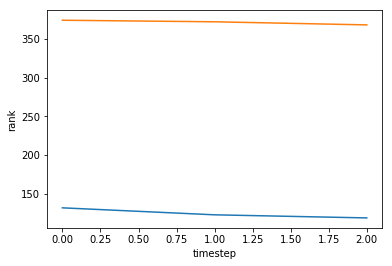


Application: Closure
Bug Nr:43

Number of Components
1175

Faulty Component Ranking
rank: 432 com.google.javascript.jscomp.TypedScopeCreator$AbstractScopeBuilder#499
[2108, 0.47866033208562375]

Faulty Component Ranking for Tarantula and Ochiai
Ochiai: Best rank: 1 Avg Rank: 572 Worst Rank: 1144com.google.javascript.rhino.Node#512
[2108, 0.017933073126330058]
Tarantula: Best rank: 382 Avg Rank: 405 Worst Rank: 428com.google.javascript.jscomp.NodeTraversal#446
[2108, 0.71417087735415707]

Name of top 10 Ranking
com.google.javascript.rhino.jstype.JSType#292
com.google.javascript.rhino.jstype.FunctionType#204
com.google.javascript.jscomp.TypedScopeCreator$AbstractScopeBuilder#590
com.google.javascript.jscomp.TypedScopeCreator#142
com.google.javascript.jscomp.TypedScopeCreator$AbstractScopeBuilder#1043
com.google.javascript.jscomp.BasicErrorManager#46
com.google.javascript.jscomp.parsing.JsDocInfoParser#1073
com.google.javascript.jscomp.NodeTraversal#649
com.google.javascript.jscomp.Funct

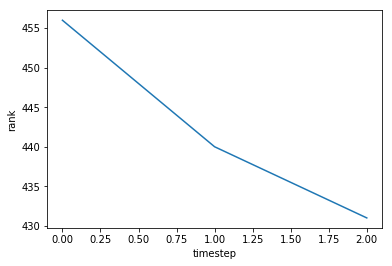


Application: Closure
Bug Nr:47

Number of Components
1046

Faulty Component Ranking
rank: 146 com.google.javascript.jscomp.SourceMap#121
[731, 0.48602720906183849]
rank: 384 com.google.debugging.sourcemap.SourceMapConsumerV3#483
[2077, 0.47627285027050997]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 1 Avg Rank: 19 Worst Rank: 38com.google.debugging.sourcemap.SourceMapGeneratorV3#367
[2077, 1.0]
Tarantula: Best rank: 95 Avg Rank: 102 Worst Rank: 109com.google.debugging.sourcemap.SourceMapGeneratorV3$MappingTraversal#585
[731, 0.99406956242987654]
Ochiai: Best rank: 1 Avg Rank: 399 Worst Rank: 797com.google.javascript.jscomp.Compiler#1726
[731, 0.050791859225274891]
Ochiai: Best rank: 857 Avg Rank: 876 Worst Rank: 896com.google.javascript.jscomp.PhaseOptimizer#141
[2077, 0.025395929612637445]

Name of top 10 Ranking
com.google.debugging.sourcemap.SourceMapGeneratorV3#367
com.google.debugging.sourcemap.SourceMapGeneratorV3#276
com.google.debugging.sourcemap.S

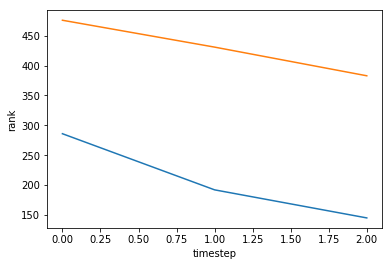


Application: Closure
Bug Nr:49

Number of Components
1129

Faulty Component Ranking
rank: 236 com.google.javascript.jscomp.MakeDeclaredNamesUnique#116
[712, 0.49964039577371078]
rank: 613 com.google.javascript.jscomp.MakeDeclaredNamesUnique#157
[949, 0.48729972738636845]
rank: 767 com.google.javascript.jscomp.MakeDeclaredNamesUnique#77
[403, 0.48204910958972597]

Faulty Component Ranking for Tarantula and Ochiai
Ochiai: Best rank: 1 Avg Rank: 271 Worst Rank: 541com.google.javascript.jscomp.parsing.IRFactory$TransformDispatcher#851
[403, 0.19282919538168825]
Ochiai: Best rank: 1 Avg Rank: 271 Worst Rank: 541com.google.javascript.rhino.jstype.StringType#92
[712, 0.19282919538168825]
Ochiai: Best rank: 1 Avg Rank: 271 Worst Rank: 541com.google.javascript.jscomp.GoogleCodingConvention#91
[949, 0.19282919538168825]
Tarantula: Best rank: 419 Avg Rank: 422 Worst Rank: 426com.google.javascript.jscomp.InlineCostEstimator$CompiledSizeEstimator#76
[403, 0.54817788758492891]
Tarantula: Best rank:

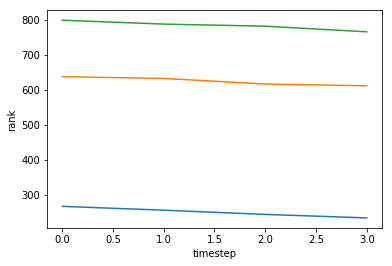


Application: Closure
Bug Nr:72

Number of Components
824

Faulty Component Ranking
rank: 8 com.google.javascript.jscomp.FunctionToBlockMutator#143
[860, 0.51379192145261743]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 30 Avg Rank: 35 Worst Rank: 40com.google.javascript.rhino.jstype.FunctionPrototypeType#67
[860, 0.74821428571428572]
Ochiai: Best rank: 1 Avg Rank: 412 Worst Rank: 824com.google.javascript.jscomp.DefaultCodingConvention#66
[860, 0.048853196874603148]

Name of top 10 Ranking
com.google.javascript.rhino.Node#918
com.google.javascript.jscomp.CodeGenerator#836
com.google.javascript.jscomp.AstValidator#303
com.google.javascript.jscomp.parsing.IRFactory$TransformDispatcher#681
com.google.javascript.rhino.Node#173
com.google.javascript.jscomp.parsing.IRFactory$TransformDispatcher#676
com.google.javascript.jscomp.InlineFunctions$FindCandidatesReferences#511
com.google.javascript.jscomp.FunctionToBlockMutator#143
com.google.javascript.jscomp.InlineFun

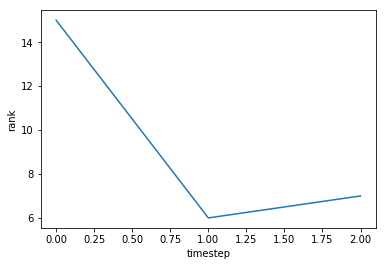


Application: Closure
Bug Nr:76

Number of Components
718

Faulty Component Ranking
rank: 21 com.google.javascript.jscomp.DeadAssignmentsElimination#292
[1358, 0.53461354266979766]
rank: 22 com.google.javascript.jscomp.DeadAssignmentsElimination#341
[1484, 0.53451807461530298]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 18 Avg Rank: 18 Worst Rank: 18com.google.javascript.jscomp.parsing.IRFactory$TransformDispatcher#753
[1484, 0.88793103448275867]
Tarantula: Best rank: 25 Avg Rank: 25 Worst Rank: 25com.google.javascript.rhino.Node#1792
[1358, 0.83064516129032262]
Ochiai: Best rank: 1 Avg Rank: 341 Worst Rank: 681com.google.javascript.jscomp.Scope#484
[1358, 0.19706585563285864]
Ochiai: Best rank: 1 Avg Rank: 341 Worst Rank: 681com.google.javascript.jscomp.Scope$Var#133
[1484, 0.19706585563285864]

Name of top 10 Ranking
com.google.javascript.rhino.Node#1057
com.google.javascript.rhino.Node#908
com.google.javascript.rhino.Node#1048
com.google.javascript.rhino

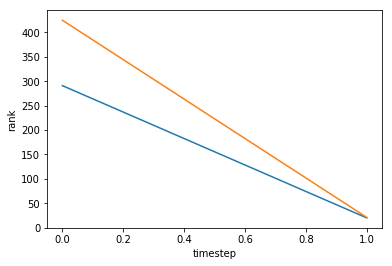


Application: Closure
Bug Nr:103

Number of Components
998

Faulty Component Ranking
rank: 546 com.google.javascript.jscomp.ControlFlowAnalysis#885
[2640, 0.4769211456557611]
rank: 794 com.google.javascript.jscomp.DisambiguateProperties$JSTypeSystem#737
[2407, 0.46743210090764298]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 57 Avg Rank: 57 Worst Rank: 58com.google.javascript.jscomp.BasicErrorManager$LeveledJSErrorComparator#124
[2407, 0.92870544090056284]
Ochiai: Best rank: 1 Avg Rank: 176 Worst Rank: 352com.google.javascript.rhino.jstype.FunctionPrototypeType#80
[2640, 0.044946657497549475]
Tarantula: Best rank: 208 Avg Rank: 208 Worst Rank: 209com.google.javascript.rhino.jstype.VoidType#55
[2640, 0.51473136915077988]
Ochiai: Best rank: 424 Avg Rank: 711 Worst Rank: 998com.google.javascript.rhino.jstype.JSType$1#94
[2407, 0.014982219165849825]

Name of top 10 Ranking
com.google.javascript.rhino.jstype.UnionType#373
com.google.javascript.jscomp.parsing.IRFa

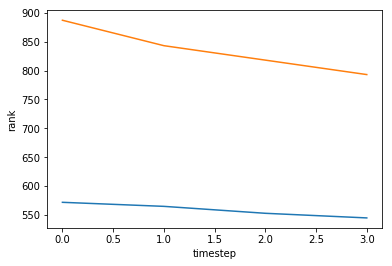


Application: Closure
Bug Nr:108

Number of Components
879

Faulty Component Ranking
rank: 12 com.google.javascript.jscomp.ScopedAliases$Traversal#358
[1962, 0.4828657258566792]
rank: 219 com.google.javascript.jscomp.ScopedAliases$Traversal#310
[1784, 0.47032106785868827]
rank: 733 com.google.javascript.jscomp.ScopedAliases$Traversal#524
[2468, 0.44460837203454912]

Faulty Component Ranking for Tarantula and Ochiai
Tarantula: Best rank: 37 Avg Rank: 39 Worst Rank: 42com.google.javascript.rhino.jstype.InstanceObjectType#176
[1962, 0.87914230019493178]
Tarantula: Best rank: 106 Avg Rank: 111 Worst Rank: 116com.google.javascript.rhino.Node#1097
[2468, 0.62988826815642462]
Tarantula: Best rank: 106 Avg Rank: 111 Worst Rank: 116com.google.javascript.rhino.jstype.UnionTypeBuilder#100
[1784, 0.62988826815642462]
Ochiai: Best rank: 1 Avg Rank: 440 Worst Rank: 879com.google.javascript.rhino.jstype.NumberType#97
[2468, 0.047088160934801108]
Ochiai: Best rank: 1 Avg Rank: 440 Worst Rank: 879com.g

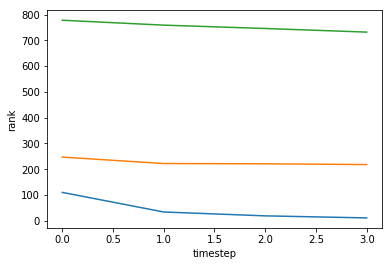

In [21]:
for application_i in range(len(fault_nr)):
    for fault_nr_j in range(len(fault_nr[application_i])):
        print("Application: "+str(applications[application_i])+"\nBug Nr:"+str(fault_nr[application_i][fault_nr_j])+"\n")
        
        #Get all rankings and sort ranking
        ranking = top_ranking[application_i][fault_nr_j]
        tarantula_ranking = tarantula_ranking_all[application_i][fault_nr_j]
        ochiai_ranking = ochiai_ranking_all[application_i][fault_nr_j]
        original_ranking = copy.deepcopy(ranking)
        ranking.sort(key=operator.itemgetter(1), reverse=True)
        
        #names and ids of all faulty component
        faulty_comps = faulty_component_list[application_i][fault_nr_j]
        faulty_component_names_list = faulty_component_names(application_i, fault_nr_j)
        
        
        #Evaluation prints
        print("Number of Components")
        print(str(len(ranking))+"\n")

        print("Faulty Component Ranking")
        for i in range(len(ranking)):
            if ranking[i][0] in faulty_comps:
                print("rank: "+str(i+1)+" "+str(faulty_component_names_list[ranking[i][0]]))
                print(ranking[i])
        #print(ranking)
        print()
        
        print("Faulty Component Ranking for Tarantula and Ochiai")
        t_best, t_avg, t_worst = get_ranks(tarantula_ranking)
        o_best, o_avg, o_worst = get_ranks(ochiai_ranking)
        for i in range(len(ranking)):
            if tarantula_ranking[i][0] in faulty_comps:
                print("Tarantula: Best rank: "+str(t_best[i][2])+" Avg Rank: "+str(t_avg[i][2])+" Worst Rank: "+str(t_worst[i][2])+str(faulty_component_names_list[ranking[i][0]]))
                print(tarantula_ranking[i])
            if ochiai_ranking[i][0] in faulty_comps:
                print("Ochiai: Best rank: "+str(o_best[i][2])+" Avg Rank: "+str(o_avg[i][2])+" Worst Rank: "+str(o_worst[i][2])+str(faulty_component_names_list[ranking[i][0]]))
                print(ochiai_ranking[i])
        #print(ranking)
        print()
        
        print("Name of top 10 Ranking")
        for i in range(np.minimum(len(ranking),10)):
            print(str(faulty_component_names_list[ranking[i][0]]))

        print()
        print("Suspiciousness of top 10 Ranking")
        for i in range(np.minimum(len(ranking),10)):
            print(str(ranking[i]))

        #print ranks for all faulty components (not just first hit here)
        print()
        flag = True
        print("&"+str(len(ranking))+"&", end='')
        for i in range(np.minimum(len(ranking),10)):
            print(str(ranking[i][0])+" & ", end='')
        for i in range(len(ranking)):
            if ranking[i][0] in faulty_comps:
                if flag:
                    print("rank: ", end='')
                    flag = False
                print(str(i+1)+" ("+str(ranking[i][0])+")&", end='')
            #print(ranking[i])

        
        
        
        #Ranking Over Time
        rank_over_time = ranking_over_time_all[application_i][fault_nr_j]
        component_dict = {}
        for i in range(len(faulty_component_list[application_i][fault_nr_j])):
            component_dict[faulty_component_list[application_i][fault_nr_j][i]] = i

        for i in range(len(ranking)):
            if ranking[i][0] in faulty_comps:
                #print(component_dict[ranking[i][0]])
                #print(rank_over_time[component_dict[ranking[i][0]]])
                plt.plot([j for j in range(len(rank_over_time[component_dict[ranking[i][0]]]))],rank_over_time[component_dict[ranking[i][0]]])

        plt.ylabel("rank")
        plt.xlabel("timestep")
        plt.savefig("./pictures/"+str(application_i+1)+'_'+str(fault_nr_j+1)+'_rank_over_time')
        plt.show()
        
        
        
        
        print("=========================================================\n"+
        "=========================================================\n"+
        "=========================================================\n")

### Find Wasted Effort
Wasted effort was included in the original proposal, but it did not add much value to the evaluation and was scrapped. However, I wanted to keep the code.

In [22]:
def get_wasted_effort(application_i, fault_nr_j, ranking, faulty_comps):
    
    cur_waste = 0
    correction_sum = 0 #for average_break rank computation
    last = -1

    for i in range(len(ranking)):
        if ranking[i][0] in faulty_comps:
            if ranking[i][2]!=last:
                cur_waste += correction_sum
                break
            else:
                for j in range(i+1, len(ranking)):
                    if ranking[j][2] != last:
                        cur_waste += correction_sum//2
                        break
                    elif i!=j:
                        if faulty_component_names_list[ranking[i][0]] in method_len_dict:
                            correction_sum+=method_len_dict[faulty_component_names_list[ranking[i][0]]]
                        else: 
                            correction_sum+=1
                break
        else:
            if last == ranking[i][2]:
                if faulty_component_names_list[ranking[i][0]] in method_len_dict:
                    correction_sum+=method_len_dict[faulty_component_names_list[ranking[i][0]]]
                else: 
                    correction_sum+=1
            else:
                cur_waste+=correction_sum
                correction_sum = 0
                
                if faulty_component_names_list[ranking[i][0]] in method_len_dict:
                    correction_sum+=method_len_dict[faulty_component_names_list[ranking[i][0]]]
                else: 
                    correction_sum+=1
            #The wasted effort tool for line calculation did not take header line into account 
            #(which normally doesn't matter). However, in most of the projects, 
            #actual oneliners were paired with the header line to keep it "clean". 
            #Thus any component not showing up here is a oneliner in the project
    
    return cur_waste

In [23]:
wasted_effort =  [[] for i in range(len(fault_nr))]
wasted_effort_tarantula =  [[] for i in range(len(fault_nr))]
wasted_effort_ochiai =  [[] for i in range(len(fault_nr))]
counter = 0

for application_i in range(len(fault_nr)):
    for fault_nr_j in range(len(fault_nr[application_i])):
        comp_len_dir = "./data/"+applications[application_i]+"/"+applications[application_i]+"_"+str(fault_nr[application_i][fault_nr_j])+"/component_lengths/method_spectra"
        comp_len_file = open(comp_len_dir)
        
        method_len_dict = {}
        
        for line in comp_len_file.readlines():
            key = line.split(":")[0]+"#"+str(int(line.split("#")[1].split(":")[0])+1)
            #print(key)
            method_len_dict[key] = int(line.split(":")[2].split(",")[2])-int(line.split(":")[2].split(",")[0])
            
        
        _, ranking, _ = get_ranks(top_ranking[application_i][fault_nr_j])
        _, tarantula_ranking, _ = get_ranks(tarantula_ranking_all[application_i][fault_nr_j])
        _, ochiai_ranking, _ = get_ranks(ochiai_ranking_all[application_i][fault_nr_j])
        faulty_comps = faulty_component_list[application_i][fault_nr_j]
        faulty_component_names_list = faulty_component_names(application_i, fault_nr_j)
        
        wasted_effort[application_i].append(get_wasted_effort(application_i, fault_nr_j, ranking, faulty_comps))
        wasted_effort_tarantula[application_i].append(get_wasted_effort(application_i, fault_nr_j, tarantula_ranking, faulty_comps))
        wasted_effort_ochiai[application_i].append(get_wasted_effort(application_i, fault_nr_j, ochiai_ranking, faulty_comps))
        


### Prints Table
Prints the output tables for the First Hit and Wasted Effort to files in the text_out folder.

In [24]:
filename = './text_out/First_Hit.txt'
file = open(filename,'w')

file.write("\\begin{tabular}{|c|c|c|c|}\n\\hline\n")
file.write("Buggy version & M & T & O\\\\\\hline\n")

for application_i in range(len(fault_nr)):
    for fault_nr_j in range(len(fault_nr[application_i])):
        _, ranking, _ = get_ranks(top_ranking[application_i][fault_nr_j])
        _, tarantula_ranking, _ = get_ranks(tarantula_ranking_all[application_i][fault_nr_j])
        _, ochiai_ranking, _ = get_ranks(ochiai_ranking_all[application_i][fault_nr_j])
        faulty_comps = faulty_component_list[application_i][fault_nr_j]
        faulty_component_names_list = faulty_component_names(application_i, fault_nr_j)
        
        rank = 0
        tarantula_rank = 0
        ochiai_rank = 0
        
        for i in range(len(ranking)):
            if ranking[i][0] in faulty_comps:
                rank = ranking[i][2]
                break
                
        for i in range(len(tarantula_ranking)):
            if tarantula_ranking[i][0] in faulty_comps:
                tarantula_rank = tarantula_ranking[i][2]
                break
                
        for i in range(len(ochiai_ranking)):
            if ochiai_ranking[i][0] in faulty_comps:
                ochiai_rank = ochiai_ranking[i][2]
                break
                
        file.write(applications[application_i]+"\\_"+str(fault_nr[application_i][fault_nr_j])+" & "+str(rank)+" & "+str(tarantula_rank)+" & "+str(ochiai_rank)+"\\\\\\hline\n")
                
file.write("\\end{tabular}\n")

file.close()

In [25]:
filename = './text_out/Wasted_Effort.txt'
file = open(filename,'w')

file.write("\\begin{tabular}{|c|c|c|c|}\n\\hline\n")
file.write("Buggy version& M & T & O\\\\\\hline\n")

for application_i in range(len(fault_nr)):
    for fault_nr_j in range(len(fault_nr[application_i])):
        _, ranking, _ = get_ranks(top_ranking[application_i][fault_nr_j])
        _, tarantula_ranking, _ = get_ranks(tarantula_ranking_all[application_i][fault_nr_j])
        _, ochiai_ranking, _ = get_ranks(ochiai_ranking_all[application_i][fault_nr_j])
        faulty_comps = faulty_component_list[application_i][fault_nr_j]
        faulty_component_names_list = faulty_component_names(application_i, fault_nr_j)
        
        wasted = wasted_effort[application_i][fault_nr_j]
        tarantula_wasted = wasted_effort_tarantula[application_i][fault_nr_j]
        ochiai_wasted = wasted_effort_ochiai[application_i][fault_nr_j]
                
        file.write(applications[application_i]+"\\_"+str(fault_nr[application_i][fault_nr_j])+" & "+str(wasted)+" & "+str(tarantula_wasted)+" & "+str(ochiai_wasted)+"\\\\\\hline\n")
                
file.write("\\end{tabular}\n")
file.close()